# Regression of Used Car Prices

In [330]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import uniform, randint

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from optuna.samplers import TPESampler

import category_encoders as ce

from catboost import CatBoostRegressor
from catboost import Pool

import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression


import shap
import optuna


In [230]:
data = pd.read_csv('train.csv')
data.head()


id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

In [231]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


Рассмотрим столбцы:
1. id - совпадает с индексом нашей строки
2. brand - марка автомобиля
3. model - модель автомобиля
4. model_year - год выпуска
5. milage - пробег
6. fuel_type - тип топлива
7. engine - двигатель(мощность + объём + кол-во цилиндров + тип двигателя + тип топлива)
8. transmission - тип коробки передач
9. ext_col - цвет автомобиля
10. int_col - цвет салона
11. accident - информация о ДТП
12. clean_title - статус юридической чистоты автомобиля 
13. price - цена автомобиля

# Exploratiry Data Analysis

In [232]:
# Удалим столбец id
data = data.drop(columns = ['id'])
data.head()

brand              model  model_year  milage      fuel_type  \
0           MINI      Cooper S Base        2007  213000       Gasoline   
1        Lincoln              LS V8        2002  143250       Gasoline   
2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T    Blue    Gray   
3  Transmission w/Dual Shift Mode   Black   Black   
4                     7-Speed A/T   Black   Beige   

                                 accident clean_title  price  
0                           None reported         Yes   4200  
1  At least 1 accident or damage reported         Yes   4999  
2                           None reported         Yes  13900  
3                           None reported         Yes  45000  
4                           None reported         Yes  97500

In [233]:
# Создадим список категориальных фичей
categorical_columns = data.select_dtypes(include=['object','category']).columns.to_list()
# Создадим список числовых фичей
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.difference(['price','id']).to_list()
# Создадим target с ценами автомобилей
target = 'price'

print("Categorical_columns:")
print(categorical_columns)
print("Numerical_columns:")
print(numerical_columns)

print()

Categorical_columns:
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical_columns:
['milage', 'model_year']



# Data processing

In [234]:
# Посмотрим,сколько пропусков у нас в каждом признаке и какой процент от всех данных составляют пропуски
total_rows = len(data)
missing_counts = data.isnull().sum()
missing_percentage = (missing_counts / total_rows) * 100

missing_data = pd.DataFrame({
    'Feature': missing_counts.index,  # Название признаков
    'Missing Count': missing_counts.values,  # Количество пропусков
    'Missing Percentage': missing_percentage.values  # Процент пропусков
})

# Сортировка по убыванию количества пропусков
missing_data = missing_data.sort_values(by=['Missing Count', 'Missing Percentage'], ascending=False)
print(missing_data)

         Feature  Missing Count  Missing Percentage
10   clean_title          21419           11.360876
4      fuel_type           5083            2.696080
9       accident           2452            1.300568
0          brand              0            0.000000
1          model              0            0.000000
2     model_year              0            0.000000
3         milage              0            0.000000
5         engine              0            0.000000
6   transmission              0            0.000000
7        ext_col              0            0.000000
8        int_col              0            0.000000
11         price              0            0.000000


У нас пропуски в столбцах: clean_title(11%),fuel_type(2.7%) и accident(1.3%):
1. Пропуски в clean_title логичнее всего заполнить NO - то есть у автомобиля нет юридической чистоты,раз это не указано.
2. Пропущенные значения в fuel_type можем достать из столбца engine.
3. Пропуски в accident можно заполнить At least 1 accident or damage reported,раз не указано None reported,значит скорее всего были ДТП.

In [235]:
data['accident'] = data['accident'].fillna('At least 1 accident or damage reported')
data['clean_title'] = data['clean_title'].fillna('NO')

In [236]:
data['fuel_type'] = data['fuel_type'].fillna('electric')

In [237]:
# Проверим,что заполнили все пропущенные значения
missing_counts = data.isna().sum().sum()
print(missing_counts)

0


Заполнили все пропуски в датасете.

In [238]:
# Разделим наши данные на тренировочную и тестовую выборку
X = data.drop('price',axis = 1)
y = data['price']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [239]:
# Целевая кодировка категориальных признаков
target_encoder = ce.TargetEncoder(cols=categorical_columns)

In [240]:
# Обучаем кодировщик на тренировочных данных и применяем его
X_train_full = target_encoder.fit_transform(X_train_full, y_train_full)
X_test = target_encoder.transform(X_test)

In [241]:
X_train_full.head()

brand         model  model_year  milage     fuel_type  \
184031  51076.554126  25956.284654        2017   61675  27192.645795   
173831  28973.493523  16884.559426        2003  185000  43334.276214   
183819  40948.873763  43063.632584        2020   92000  43334.276214   
85525   25834.729909  42868.037174        2023    5483  43334.276214   
41872   33359.465358  73888.852797        2023    5000  43334.276214   

              engine  transmission       ext_col       int_col      accident  \
184031  33819.246017  50140.517038  47823.737565  45550.650737  27055.965906   
173831  12438.203692  31892.612674  32123.241021  27986.298258  27055.965906   
183819  39480.854195  58422.036009  47823.737565  27986.298258  27055.965906   
85525   47903.594138  33287.833627  42218.214062  45550.650737  49015.236264   
41872   77614.057412  25901.264263  39705.577817  45550.650737  49015.236264   

         clean_title  
184031  41397.777682  
173831  41397.777682  
183819  41397.777682  
85525   63440.828995  
41872   41397.777682

In [242]:
# Масштабируем наши признаки
scaler = StandardScaler()
scaler.fit(X_train_full)
X_train_full = scaler.transform(X_train_full)
X_test = scaler.transform(X_test)

In [243]:
X_train_full = pd.DataFrame(X_train_full)
X_test = pd.DataFrame(X_test)

/Users/vovatkachev/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


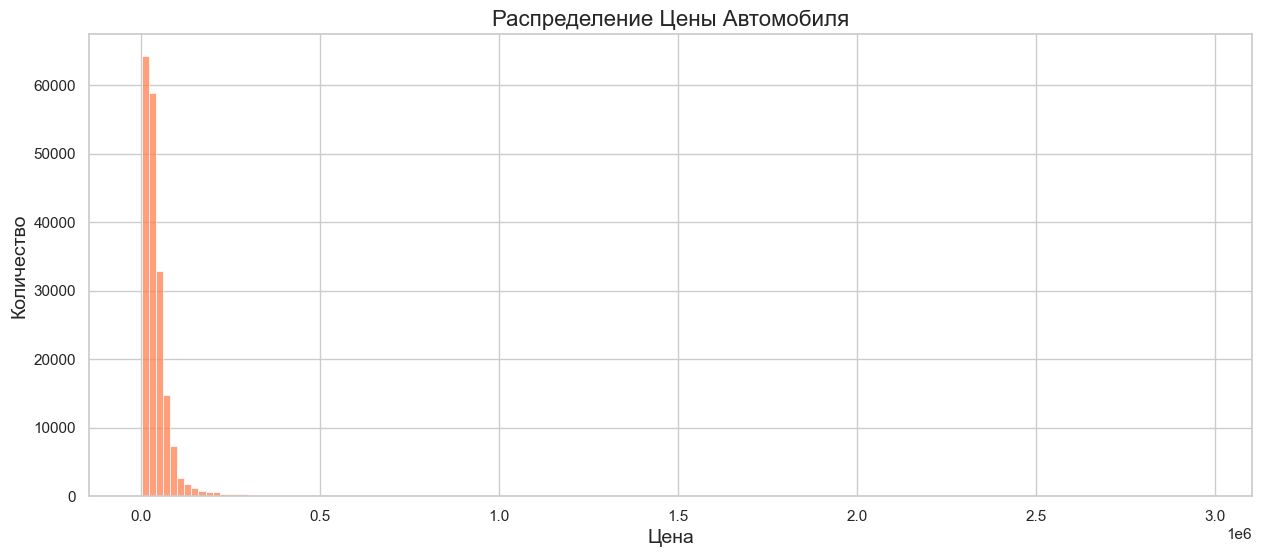

In [244]:
plt.figure(figsize=(15, 6))
sns.histplot(y, bins=150, kde=False, color='coral')
plt.title('Распределение Цены Автомобиля', fontsize=16)
plt.xlabel('Цена', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.show()

In [245]:
def plot_y_test_vs_y_pred(y_test, y_pred, title='True vs Predicted Values'):
    """
    Строит график с истинными значениями (y_test) и предсказанными значениями (y_pred).

    Параметры:
    - y_test: array-like или pandas Series, истинные значения.
    - y_pred: array-like или pandas Series, предсказанные значения.
    - title: str, заголовок графика.
    """
    # Преобразование pandas Series в numpy массивы, если необходимо
    if isinstance(y_test, pd.Series):
        y_test = y_test.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values

    # Проверка, что длины y_test и y_pred совпадают
    if len(y_test) != len(y_pred):
        raise ValueError("Длины y_test и y_pred должны совпадать.")

    # Создание массива индексов для оси X
    x = np.arange(len(y_test))

    plt.figure(figsize=(15, 7))

    # Построение истинных значений (красные точки)
    plt.scatter(x, y_test, color='red', label='Истинные значения', alpha=0.6, edgecolors='w', s=50)

    # Построение предсказанных значений (синие точки)
    plt.scatter(x, y_pred, color='blue', label='Предсказанные значения', alpha=0.6, edgecolors='w', s=50)

    # Добавление линии тренда для истинных и предсказанных значений (опционально)
    # plt.plot(x, y_test, color='red', linestyle='-', alpha=0.5)
    # plt.plot(x, y_pred, color='blue', linestyle='--', alpha=0.5)

    # Добавление меток и заголовка
    plt.xlabel('Номер элемента', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.title(title, fontsize=16)

    # Добавление легенды
    plt.legend(fontsize=12)

    # Добавление сетки для лучшей читаемости
    plt.grid(True, linestyle='--', alpha=0.5)

    # Опционально: Ограничение диапазона по оси X, если слишком много точек
    # plt.xlim(0, len(y_test))

    # Автоматическое расположение элементов для предотвращения наложения
    plt.tight_layout()

    # Отображение графика
    plt.show()

# Пример использования:
# Предположим, что y_test и y_pred уже определены после обучения модели


In [246]:
def plot_difference(difference,title='Abs differences'):
    """
    Строит график с истинными значениями (y_test) и предсказанными значениями (y_pred).

    Параметры:
    - y_test: array-like или pandas Series, истинные значения.
    - y_pred: array-like или pandas Series, предсказанные значения.
    - title: str, заголовок графика.
    """
    # Преобразование pandas Series в numpy массивы, если необходимо
    if isinstance(difference, pd.Series):
        difference = difference.values



    # Создание массива индексов для оси X
    x = np.arange(len(y_test))

    plt.figure(figsize=(15, 7))

    # Построение истинных значений (красные точки)
    plt.scatter(x, difference, color='green',alpha=0.6, edgecolors='w', s=50)


    # Добавление меток и заголовка
    plt.xlabel('Номер элемента', fontsize=14)
    plt.ylabel('Модуль ошибки', fontsize=14)
    plt.title(title, fontsize=16)

    # Добавление легенды
    plt.legend(fontsize=12)

    # Добавление сетки для лучшей читаемости
    plt.grid(True, linestyle='--', alpha=0.5)

    # Опционально: Ограничение диапазона по оси X, если слишком много точек
    # plt.xlim(0, len(y_test))

    # Автоматическое расположение элементов для предотвращения наложения
    plt.tight_layout()

    # Отображение графика
    plt.show()



In [247]:
def differenceBetweenModels(first_pred,second_pred, third_pred, title='True vs Predicted Values'):
    """
    Строит график с истинными значениями (y_test) и предсказанными значениями (y_pred).

    Параметры:
    - y_test: array-like или pandas Series, истинные значения.
    - y_pred: array-like или pandas Series, предсказанные значения.
    - title: str, заголовок графика.
    """
    # Преобразование pandas Series в numpy массивы, если необходимо
    if isinstance(first_pred, pd.Series):
        first_pred = first_pred.values
    if isinstance(second_pred, pd.Series):
        second_pred = second_pred.values
    if isinstance(third_pred, pd.Series):
        third_pred = third_pred.values



    # Создание массива индексов для оси X
    x = np.arange(len(y_test))

    plt.figure(figsize=(15, 7))

    # Построение истинных значений (красные точки)
    plt.scatter(x, first_pred, color='red', label='Ошибки первой модели', alpha=0.6, edgecolors='w', s=50)

    # Построение предсказанных значений (синие точки)
    plt.scatter(x, second_pred, color='blue', label='Ошибки второй модели', alpha=0.6, edgecolors='w', s=50)

    # Построение предсказанных значений (синие точки)
    plt.scatter(x, third_pred, color='green', label='Ошибки третьей модели', alpha=0.6, edgecolors='w', s=50)

    # Добавление линии тренда для истинных и предсказанных значений (опционально)
    # plt.plot(x, y_test, color='red', linestyle='-', alpha=0.5)
    # plt.plot(x, y_pred, color='blue', linestyle='--', alpha=0.5)

    # Добавление меток и заголовка
    plt.xlabel('Номер элемента', fontsize=14)
    plt.ylabel('Значение', fontsize=14)
    plt.title(title, fontsize=16)

    # Добавление легенды
    plt.legend(fontsize=12)

    # Добавление сетки для лучшей читаемости
    plt.grid(True, linestyle='--', alpha=0.5)

    # Опционально: Ограничение диапазона по оси X, если слишком много точек
    # plt.xlim(0, len(y_test))

    # Автоматическое расположение элементов для предотвращения наложения
    plt.tight_layout()

    # Отображение графика
    plt.show()

# Пример использования:
# Предположим, что y_test и y_pred уже определены после обучения модели


In [248]:
# Разделение обучающих данных на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, shuffle = True
)

# Базовые модели

## 1. Catboost

### 1.1 Base model

In [249]:
params = {
    'loss_function' : 'RMSE',
    'eval_metric' : 'RMSE',
    'iterations' : 1000,
    'random_seed' : 42,
    'learning_rate' : 0.03,
    'l2_leaf_reg' : 3,
    'random_strength' : 1,
    'bagging_temperature' : 1,
    'leaf_estimation_method' : 'Newton',
    'one_hot_max_size' : 2,

}

In [250]:
cb_model = CatBoostRegressor(**params)
cb_model.fit(X_train_full,y_train_full,verbose=0)


In [251]:
# Предсказания для Catboost
cb_predictions = cb_model.predict(X_test)
cb_rmse = np.sqrt(mean_squared_error(y_test, cb_predictions))
print(f'RMSE для Catboost: {cb_rmse}')

RMSE для Catboost: 68262.6935940098


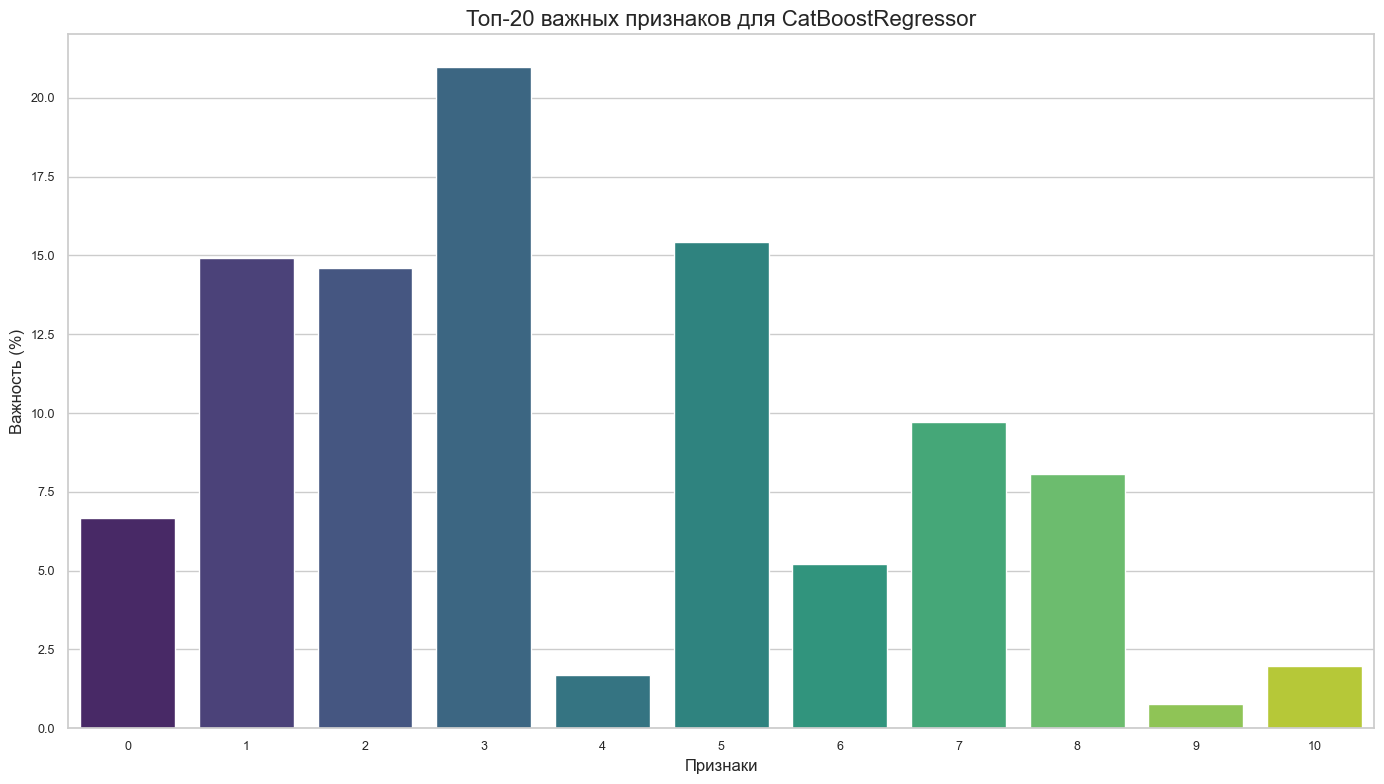

In [252]:
# Получение важности признаков
feature_importances = cb_model.get_feature_importance()

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)

sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

# Настройка заголовков и меток осей
plt.title("Топ важных признаков для CatBoostRegressor", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)

# Поворот меток оси X на 90 градусов для лучшей читаемости
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)

# Автоматическое выравнивание элементов графика
plt.tight_layout()

# Отображение графика
plt.show()

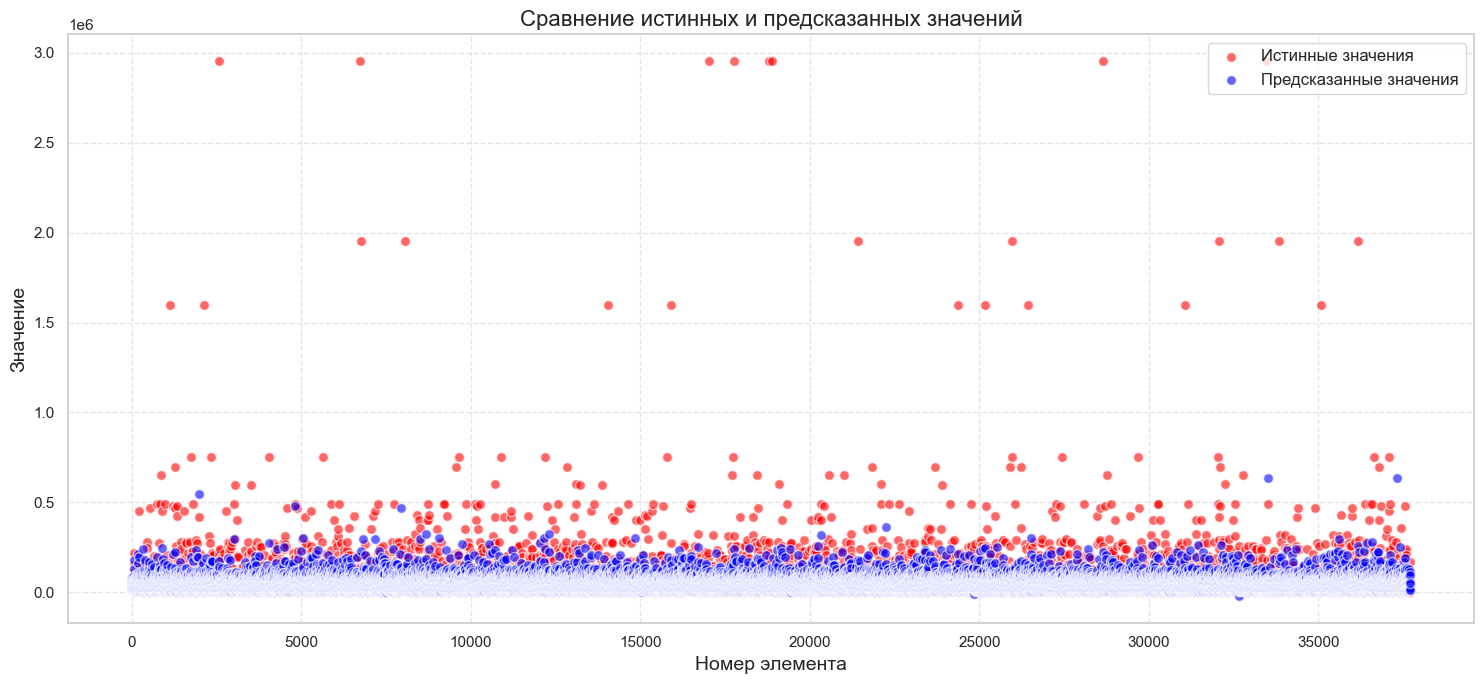

In [253]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, cb_predictions, title='Сравнение истинных и предсказанных значений')

In [254]:
difference_cb = abs(y_test - cb_predictions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


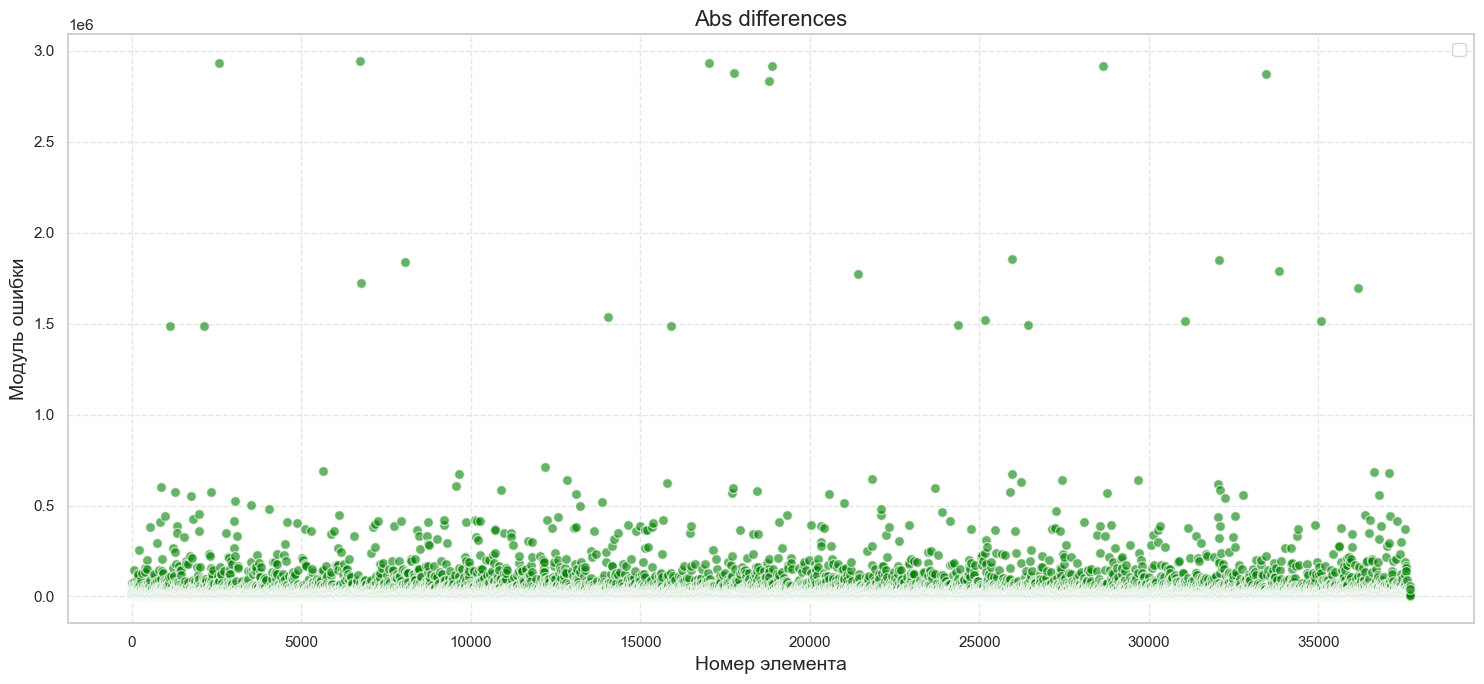

In [255]:
# Вызов функции для построения графика
plot_difference(difference_cb)

### 1.2 Optuna best model

In [256]:
# Функция для обучения модели с разными гиперпараметрами и оценки
def objective(trial):
    # Определение гиперпараметров, которые будем подбирать
    params = {
        'loss_function': 'RMSE',
        'iterations': 1000,  # Фиксируем количество итераций
        'random_seed': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 8),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 8),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 10)
    }

    # Обучение модели
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train,early_stopping_rounds=50, verbose=False)

    # Предсказания на тестовой выборке
    predictions = model.predict(X_valid)

    # Вычисление RMSE
    rmse = mean_squared_error(y_valid, predictions, squared=False)

    return rmse


In [257]:
# Создаем исследование Optuna
study = optuna.create_study(direction='minimize')  # Мы минимизируем ошибку RMSE

# Запуск подбора гиперпараметров
study.optimize(objective, n_trials=30)  # n_trials - количество итераций

[I 2024-09-25 19:50:24,172] A new study created in memory with name: no-name-715fbba4-d290-48fd-9bc5-67eaaf9d03d7


[I 2024-09-25 19:50:28,134] Trial 0 finished with value: 65586.1583615658 and parameters: {'learning_rate': 0.09854546136307636, 'l2_leaf_reg': 3.552155883299506, 'random_strength': 1.3265499478366614, 'bagging_temperature': 5.55807551782982, 'leaf_estimation_method': 'Gradient', 'one_hot_max_size': 3}. Best is trial 0 with value: 65586.1583615658.
[I 2024-09-25 19:50:31,934] Trial 1 finished with value: 66606.2346986206 and parameters: {'learning_rate': 0.09912413156157691, 'l2_leaf_reg': 2.3808749570685808, 'random_strength': 1.553849364020973, 'bagging_temperature': 6.262129555233097, 'leaf_estimation_method': 'Gradient', 'one_hot_max_size': 9}. Best is trial 0 with value: 65586.1583615658.
[I 2024-09-25 19:50:35,833] Trial 2 finished with value: 65052.89620474956 and parameters: {'learning_rate': 0.04926726829386253, 'l2_leaf_reg': 6.18546341120961, 'random_strength': 0.7807806676194586, 'bagging_temperature': 0.10336896767369996, 'leaf_estimation_method': 'Gradient', 'one_hot_max_

In [258]:
# Вывод лучших гиперпараметров
print(f'Лучшие гиперпараметры: {study.best_params}')

Лучшие гиперпараметры: {'learning_rate': 0.004505644633364947, 'l2_leaf_reg': 1.0656714366798399, 'random_strength': 0.8230917364724197, 'bagging_temperature': 2.2647196541619343, 'leaf_estimation_method': 'Newton', 'one_hot_max_size': 9}


In [259]:
# Обучение модели с лучшими гиперпараметрами
best_params_optuna = study.best_params
best_params_optuna['loss_function'] = 'RMSE'  # Не забываем добавить фиксированные параметры
best_params_optuna['iterations'] = 1000
best_params_optuna['random_seed'] = 42

model_cb_optuna = CatBoostRegressor(**best_params_optuna)
model_cb_optuna.fit(X_train_full, y_train_full, early_stopping_rounds=50, verbose=False)

In [260]:
# Получение финальных предсказаний на тестовой выборке
cb_predictions_optuna = model_cb_optuna.predict(X_test)

In [261]:
# Вычисление RMSE
rmse = mean_squared_error(y_test, cb_predictions_optuna, squared=False)

# Вывод результата
print(f'RMSE: {rmse}')

RMSE: 68100.94370075816


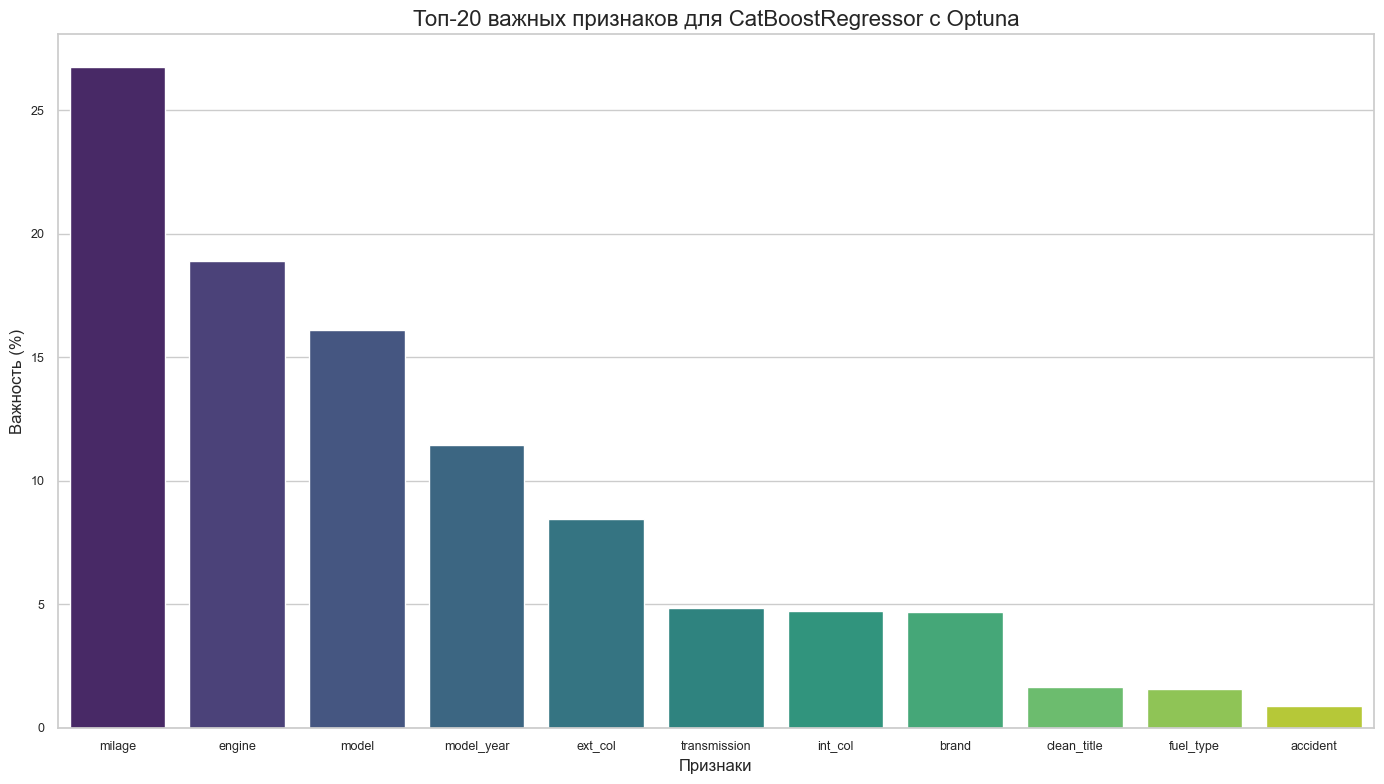

In [262]:
# Получение важности признаков
feature_importances = model_cb_optuna.get_feature_importance()

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)

sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

# Настройка заголовков и меток осей
plt.title("Топ-20 важных признаков для CatBoostRegressor c Optuna", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)

# Поворот меток оси X на 90 градусов для лучшей читаемости
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)

# Автоматическое выравнивание элементов графика
plt.tight_layout()

# Отображение графика
plt.show()

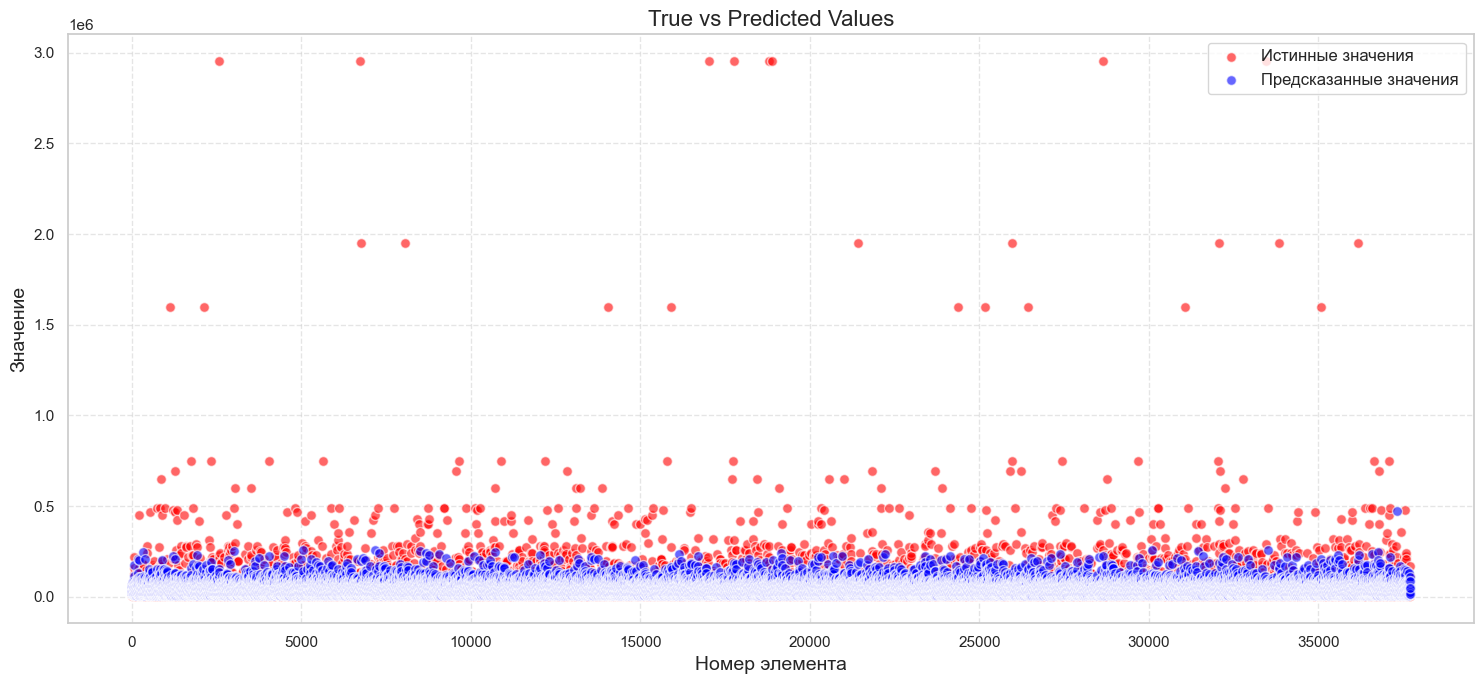

In [263]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, cb_predictions_optuna)

In [264]:
difference_cb_optuna = abs(y_test - cb_predictions_optuna)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


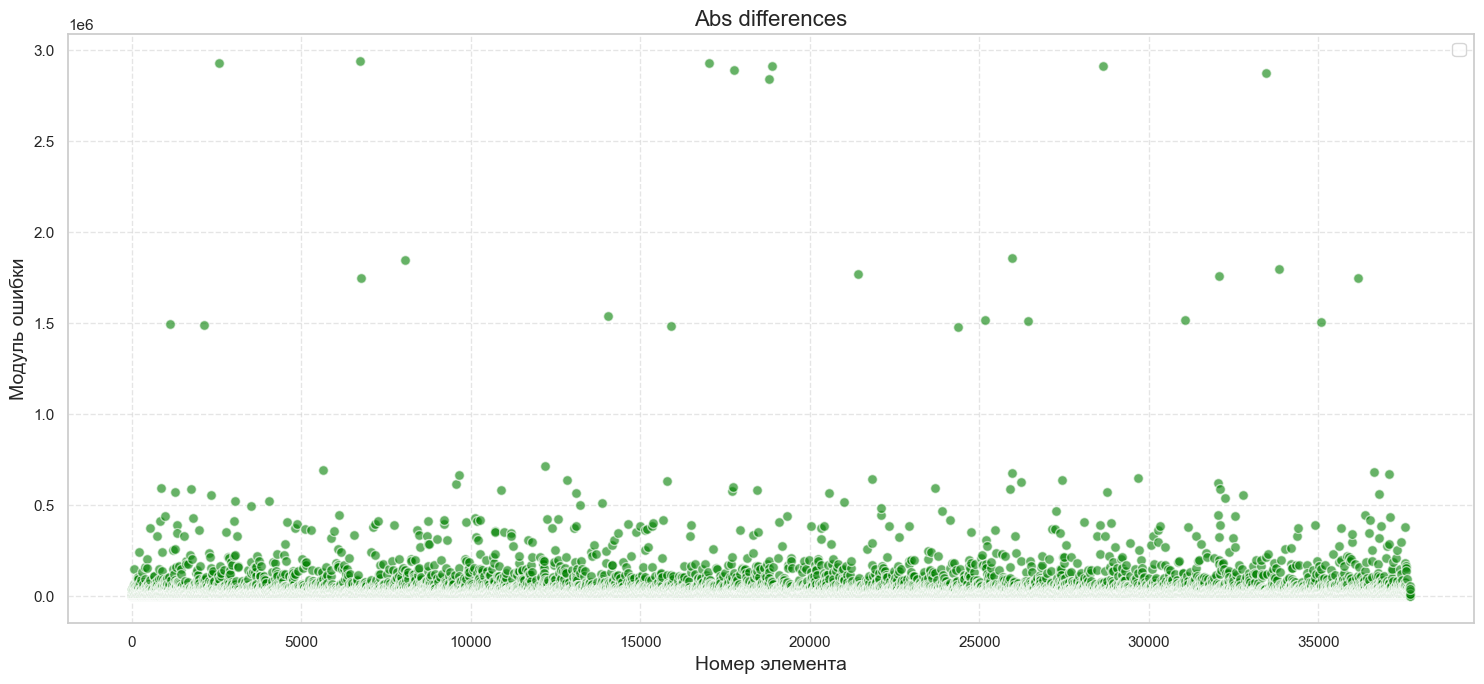

In [265]:
# Вызов функции для построения графика
plot_difference(difference_cb_optuna)

### 1.3 Random search best model

In [266]:
# Определение диапазонов гиперпараметров
param_distributions = {
    'learning_rate': uniform(0.001, 0.099),  # От 0.001 до 0.1
    'l2_leaf_reg': uniform(1, 7),            # От 1 до 8
    'random_strength': uniform(0.1, 1.9),    # От 0.1 до 2
    'bagging_temperature': uniform(0, 8),    # От 0 до 8
    'leaf_estimation_method': ['Newton', 'Gradient'],
    'one_hot_max_size': randint(2, 11),      # От 2 до 10 включительно
    'depth': randint(4, 11),                 # Добавляем гиперпараметр depth от 4 до 10
    'subsample': uniform(0.5, 0.5),          # От 0.5 до 1.0
    'colsample_bylevel': uniform(0.5, 0.5)   # От 0.5 до 1.0
}

In [267]:
# Инициализация модели CatBoostRegressor
model = CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,      # Фиксируем максимальное количество итераций
    random_seed=42,
    verbose=False
)

In [268]:
# Создание объекта RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=30,                           # Количество итераций поиска
    scoring='neg_root_mean_squared_error',
    cv=3,                                # 3-кратная кросс-валидация
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [269]:
# Обучение RandomizedSearchCV
random_search.fit(
    X_train_full,
    y_train_full
)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x2aba22550>,
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2ab913750>,
                                        'colsample_bylevel': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2ab95de50>,
                                        'depth': <scipy.stats._distn_...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x293f79090>,
                                        'one_hot_max_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2ab941dd0>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16cb94210>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2ab95d1d0>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [270]:
# Лучшие параметры
best_params_random = random_search.best_params_
print("Лучшие параметры:")
print(best_params_random)

Лучшие параметры:
{'bagging_temperature': 4.389870314932689, 'colsample_bylevel': 0.8459475988463466, 'depth': 8, 'l2_leaf_reg': 2.5698851662239184, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.002789460997936566, 'one_hot_max_size': 6, 'random_strength': 0.4397631475205247, 'subsample': 0.6832343922914299}


In [271]:
# Инициализация модели с лучшими гиперпараметрами
model_cb_random = CatBoostRegressor(
    loss_function='RMSE',
    iterations=1000,
    random_seed=42,
    verbose=False,
    **best_params_random
)

In [272]:
# Обучение модели с ранней остановкой
model_cb_random.fit(
    X_train_full,
    y_train_full,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

In [273]:
# Предсказания на тестовой выборке
cb_predictions_random = model_cb_random.predict(X_test)

# Вычисление RMSE
rmse = mean_squared_error(y_test, cb_predictions_random, squared=False)
print(f"RMSE на тестовой выборке: {rmse:.4f}")

RMSE на тестовой выборке: 68158.7081


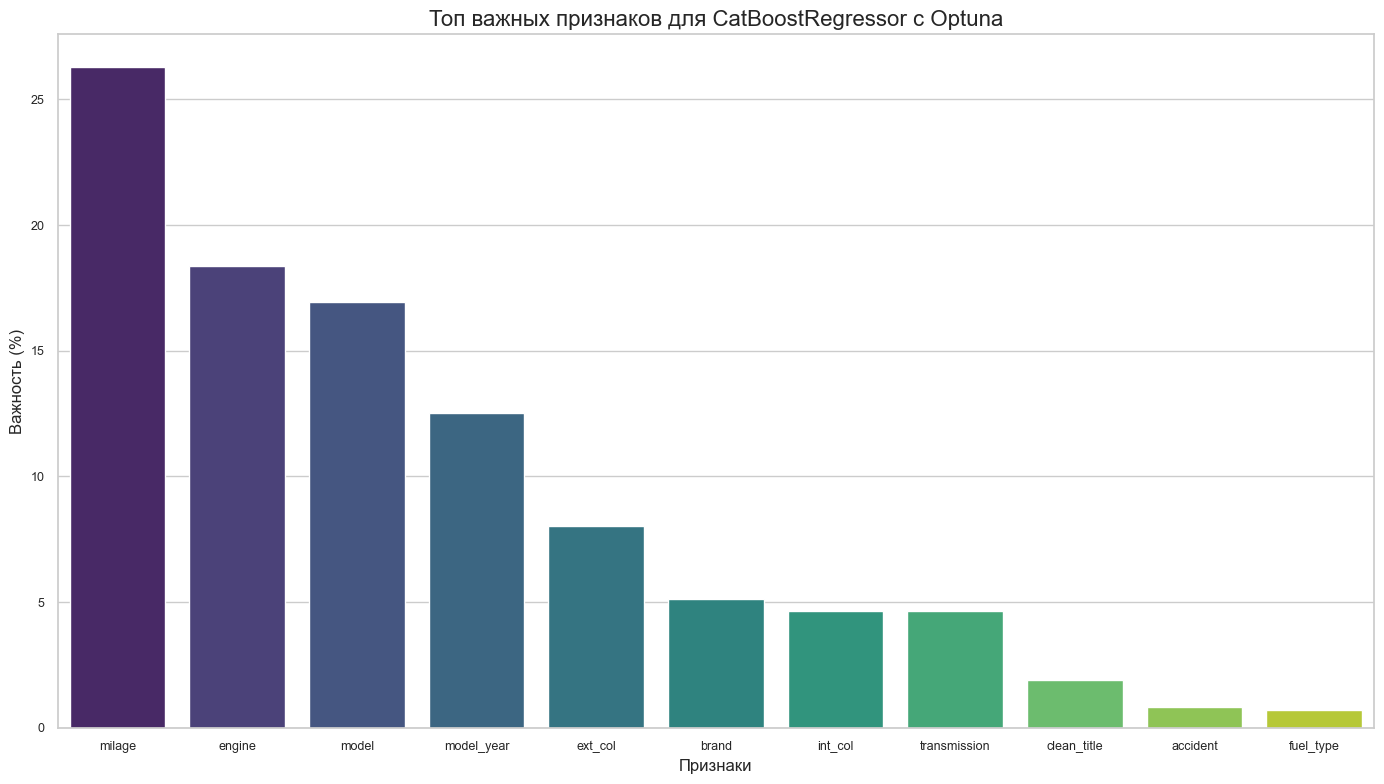

In [274]:
# Получение важности признаков
feature_importances = model_cb_random.get_feature_importance()

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)

sns.set(style="whitegrid")

# Создание графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

# Настройка заголовков и меток осей
plt.title("Топ важных признаков для CatBoostRegressor c Optuna", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)

# Поворот меток оси X на 90 градусов для лучшей читаемости
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)

# Автоматическое выравнивание элементов графика
plt.tight_layout()

# Отображение графика
plt.show()

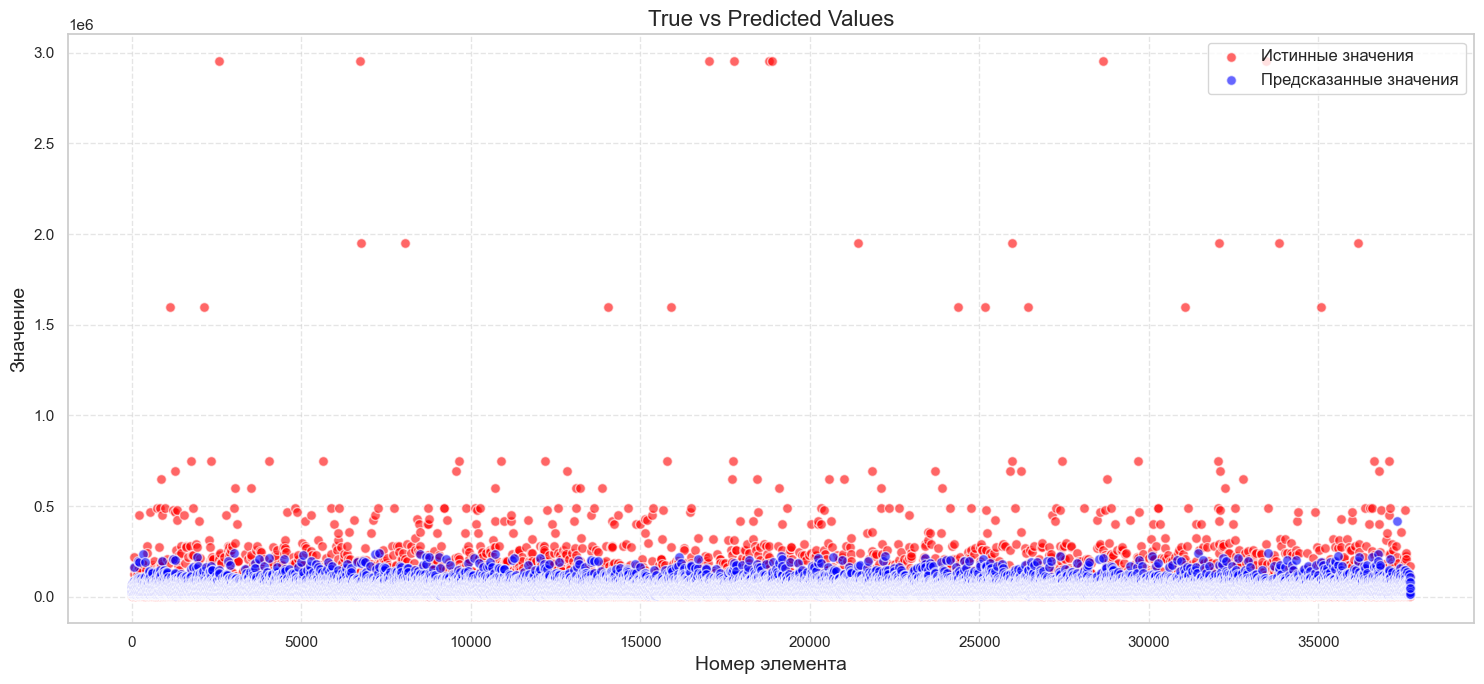

In [275]:
# Вызов функции для построения графика
plot_y_test_vs_y_pred(y_test, cb_predictions_random)

In [276]:
difference_cb_random = abs(y_test - cb_predictions_random)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


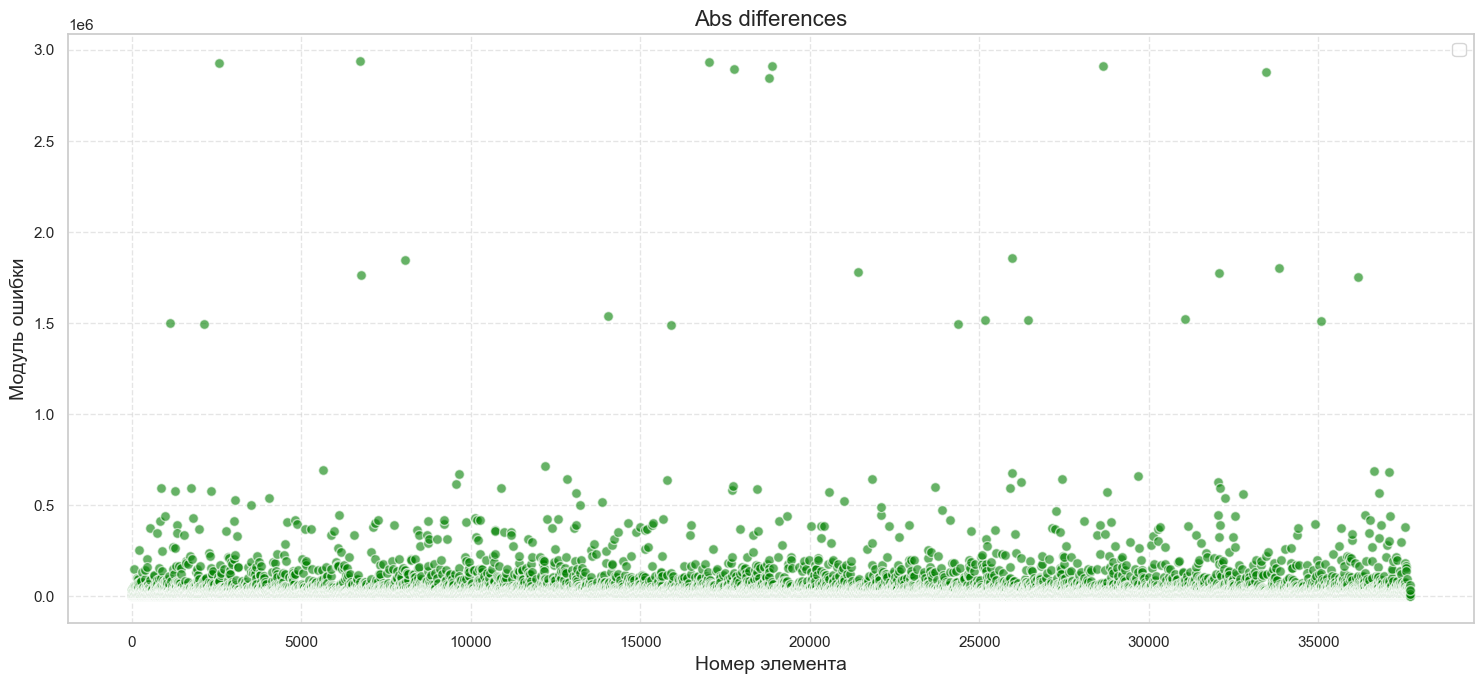

In [277]:
# Вызов функции для построения графика
plot_difference(difference_cb_random)

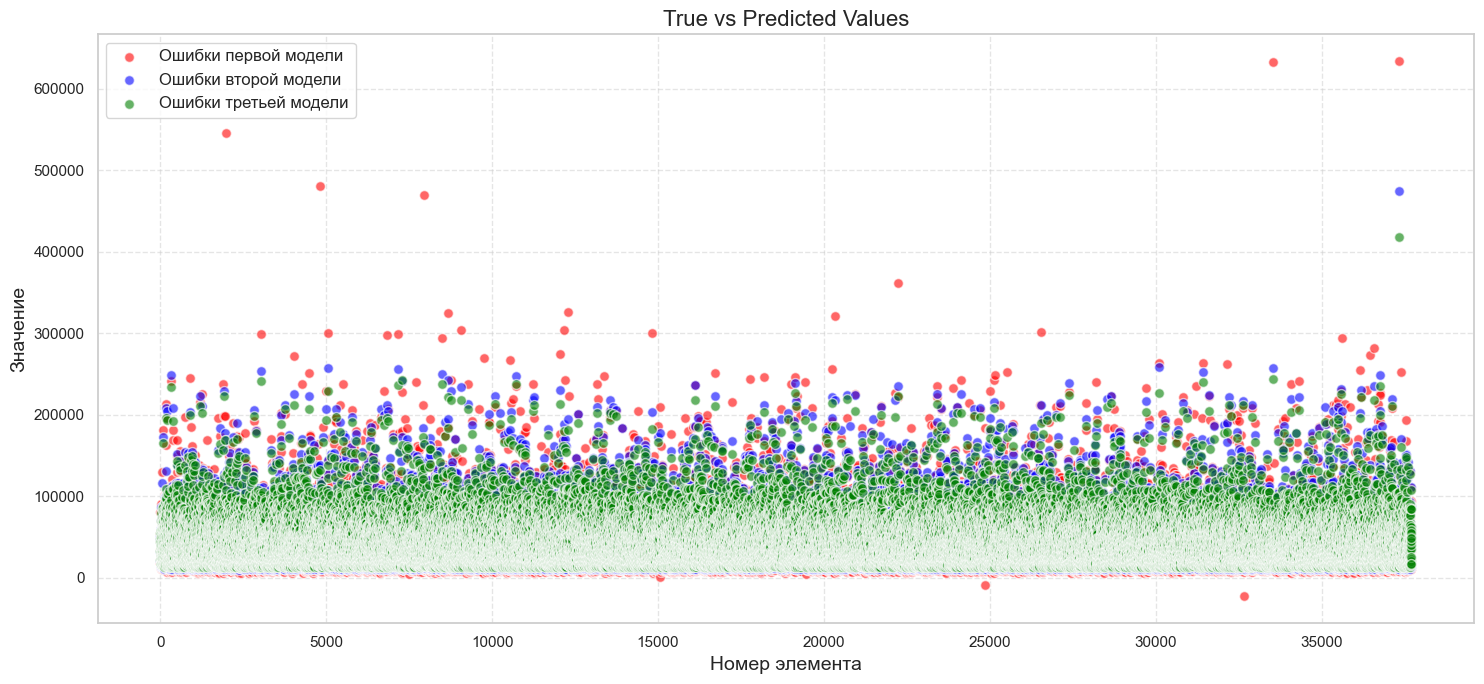

In [278]:
differenceBetweenModels(cb_predictions,cb_predictions_optuna,cb_predictions_random)

## 2. LGBM

### 2.1.Base model

In [279]:
# Обучение модели LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42,verbose = -1)
lgb_model.fit(X_train_full,
                y_train_full,
                eval_set=[(X_test, y_test)],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(10)])

Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 4.98856e+09
[20]	valid_0's l2: 4.77947e+09
[30]	valid_0's l2: 4.70298e+09
[40]	valid_0's l2: 4.67157e+09
[50]	valid_0's l2: 4.66496e+09
[60]	valid_0's l2: 4.66241e+09
[70]	valid_0's l2: 4.65967e+09
[80]	valid_0's l2: 4.65808e+09
[90]	valid_0's l2: 4.6592e+09
[100]	valid_0's l2: 4.65976e+09
[110]	valid_0's l2: 4.66348e+09
[120]	valid_0's l2: 4.66525e+09
[130]	valid_0's l2: 4.66751e+09
Early stopping, best iteration is:
[80]	valid_0's l2: 4.65808e+09


LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=1000,
              random_state=42, verbose=-1)

In [280]:
# Предсказания для LightGBM
lgb_predictions = lgb_model.predict(X_test)
lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_predictions))
print(f'RMSE для LightGBM: {lgb_rmse}')

RMSE для LightGBM: 68250.10540409038


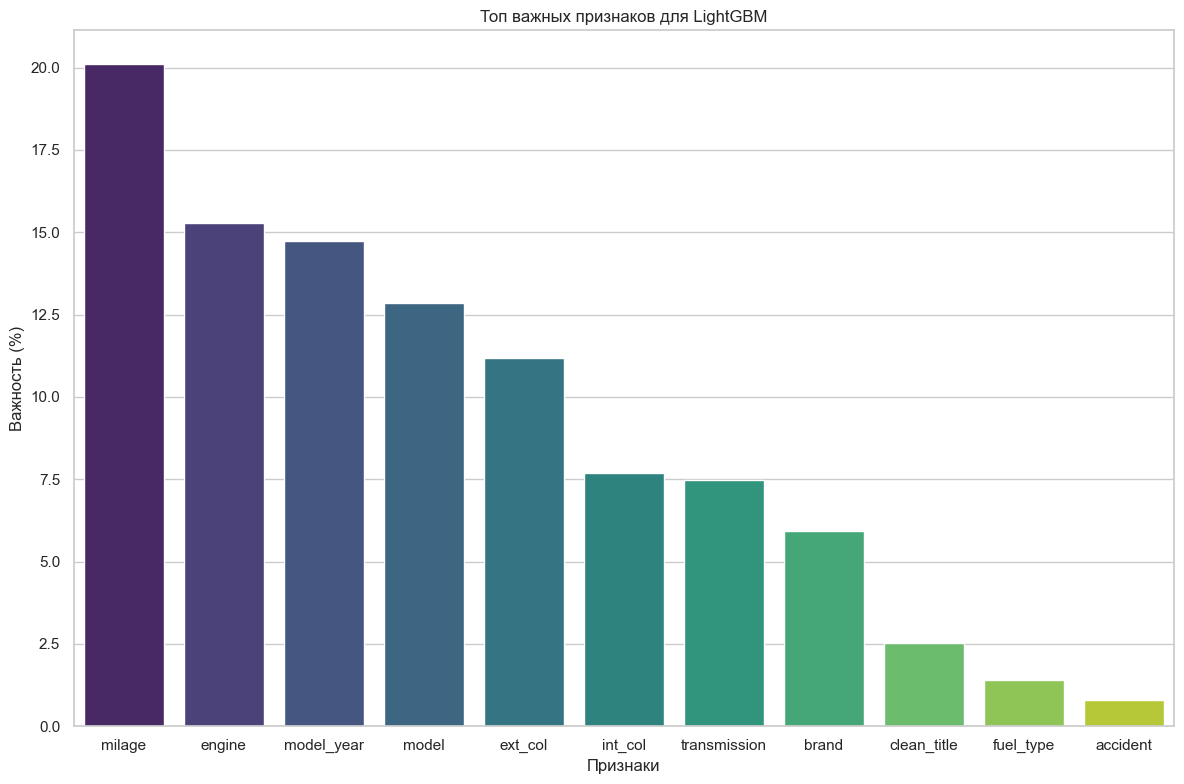

In [281]:
# Получение важности признаков
feature_importances = lgb_model.feature_importances_
feature_names = X.columns

# Создание DataFrame с важностями признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
})

# Вычисление процентной важности
importance_df['Важность (%)'] = 100 * (importance_df['Важность'] / importance_df['Важность'].sum())

# Сортировка признаков по убыванию процентной важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Отображение важности признаков в процентах
plt.figure(figsize=(12, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ важных признаков для LightGBM")
plt.xlabel("Признаки")
plt.ylabel("Важность (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

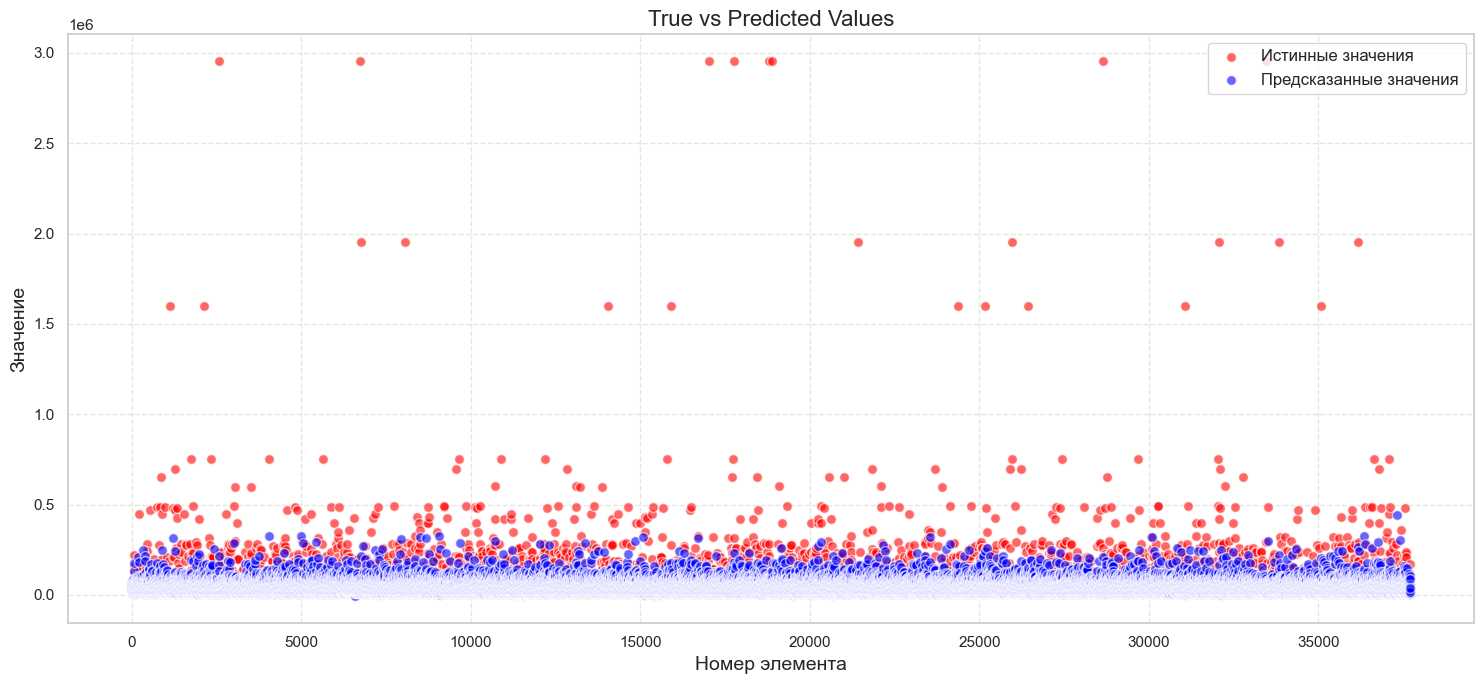

In [282]:
plot_y_test_vs_y_pred(y_test,lgb_predictions)

In [283]:
difference_lgb = abs(y_test - lgb_predictions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


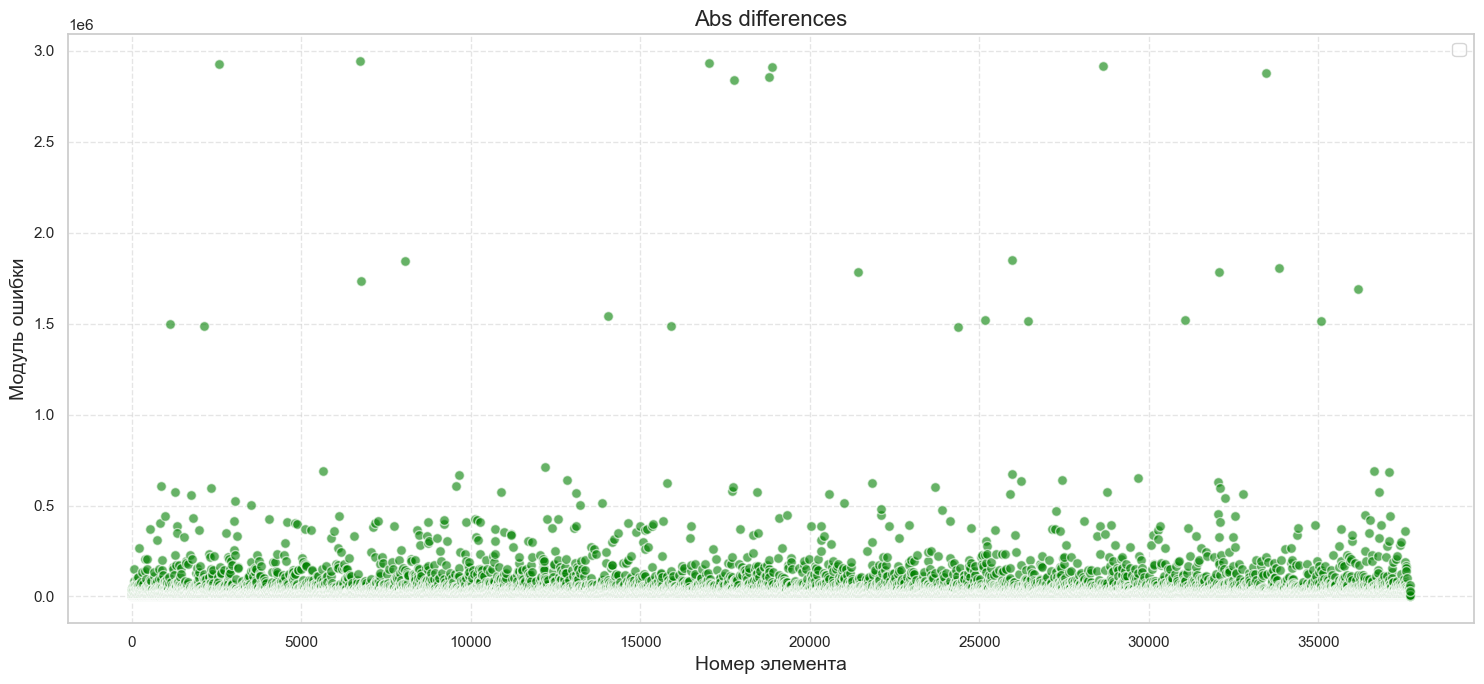

In [284]:
plot_difference(difference_lgb)

### 2.2 Optuna best model

In [285]:
# Функция цели для оптимизации гиперпараметров
def objective(trial):
    # Определяем пространство поиска гиперпараметров
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': 1000,  # Большое значение для использования ранней остановки
        'num_leaves': trial.suggest_int('num_leaves', 20, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 15.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0)
    }

    # Создаем модель с текущими гиперпараметрами
    model = LGBMRegressor(**params)

    # Обучаем модель с использованием ранней остановки
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train)],
    )

    # Предсказываем на валидационной выборке
    preds_valid = model.predict(X_valid)

    # Вычисляем RMSE на валидационной выборке
    rmse = mean_squared_error(y_valid, preds_valid, squared=False)

    return rmse

In [287]:
# Создаем объект исследования Optuna
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Запускаем оптимизацию гиперпараметров
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-09-25 21:08:02,983] A new study created in memory with name: no-name-9163a407-ef33-4623-96f5-18cf7b32a0fd


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-09-25 21:08:12,692] Trial 0 finished with value: 63469.70829338025 and parameters: {'learning_rate': 0.005611516415334507, 'num_leaves': 2854, 'max_depth': 10, 'min_data_in_leaf': 68, 'lambda_l1': 0.7800932022121826, 'lambda_l2': 0.7799726016810132, 'min_gain_to_split': 0.8712541825229919, 'bagging_fraction': 0.9197056874649611, 'bagging_freq': 5, 'feature_fraction': 0.8248435466776273}. Best is trial 0 with value: 63469.70829338025.
[I 2024-09-25 21:08:30,285] Trial 1 finished with value: 63421.3920454311 and parameters: {'learning_rate': 0.0010994335574766201, 'num_leaves': 2911, 'max_depth': 11, 'min_data_in_leaf': 37, 'lambda_l1': 0.9091248360355031, 'lambda_l2': 0.9170225492671691, 'min_gain_to_split': 4.563633644393066, 'bagging_fraction': 0.7148538589793427, 'bagging_freq': 4, 'feature_fraction': 0.5747374841188252}. Best is trial 1 with value: 63421.3920454311.
[I 2024-09-25 21:08:33,046] Trial 2 finished with value: 63470.09839685128 and parameters: {'learning_rate': 0

In [288]:
# Получаем лучшие гиперпараметры
best_params = study.best_params
print("Лучшие гиперпараметры:")
print(best_params)

Лучшие гиперпараметры:
{'learning_rate': 0.0021156005888699034, 'num_leaves': 1596, 'max_depth': 10, 'min_data_in_leaf': 91, 'lambda_l1': 3.9647786049408262, 'lambda_l2': 4.992483437747105, 'min_gain_to_split': 0.15749960571462562, 'bagging_fraction': 0.5336045114916046, 'bagging_freq': 4, 'feature_fraction': 0.6463572625880689}


In [289]:
# Обучаем финальную модель с лучшими гиперпараметрами на полном обучающем наборе
# Устанавливаем n_estimators равным лучшему количеству итераций из обучения
best_n_estimators = study.best_trial.user_attrs.get('best_iteration', 10000)

lgb_model_optuna = LGBMRegressor(
    **best_params,
    n_estimators=best_n_estimators,
    random_state=42
)

In [290]:
# Обучаем финальную модель на полном обучающем наборе
lgb_model_optuna.fit(X_train_full, y_train_full)

# Предсказываем на тестовой выборке
lgb_predictions_optuna = lgb_model_optuna.predict(X_test)

# Вычисляем RMSE на тестовой выборке
rmse_test = mean_squared_error(y_test, lgb_predictions_optuna, squared=False)
print(f"RMSE на тестовой выборке: {rmse_test:.4f}")

RMSE на тестовой выборке: 68272.4572


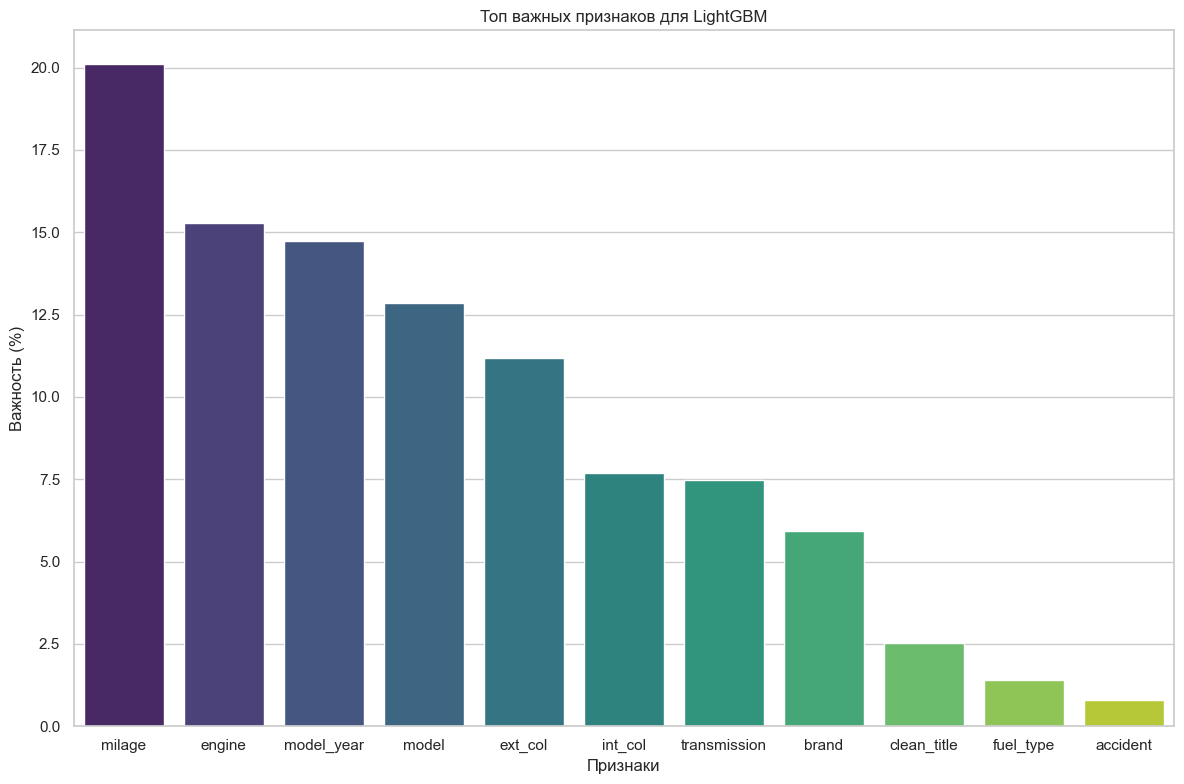

In [291]:
# Получение важности признаков
feature_importances = lgb_model.feature_importances_
feature_names = X.columns

# Создание DataFrame с важностями признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': feature_importances
})

# Вычисление процентной важности
importance_df['Важность (%)'] = 100 * (importance_df['Важность'] / importance_df['Важность'].sum())

# Сортировка признаков по убыванию процентной важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Отображение важности признаков в процентах
plt.figure(figsize=(12, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ важных признаков для LightGBM")
plt.xlabel("Признаки")
plt.ylabel("Важность (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

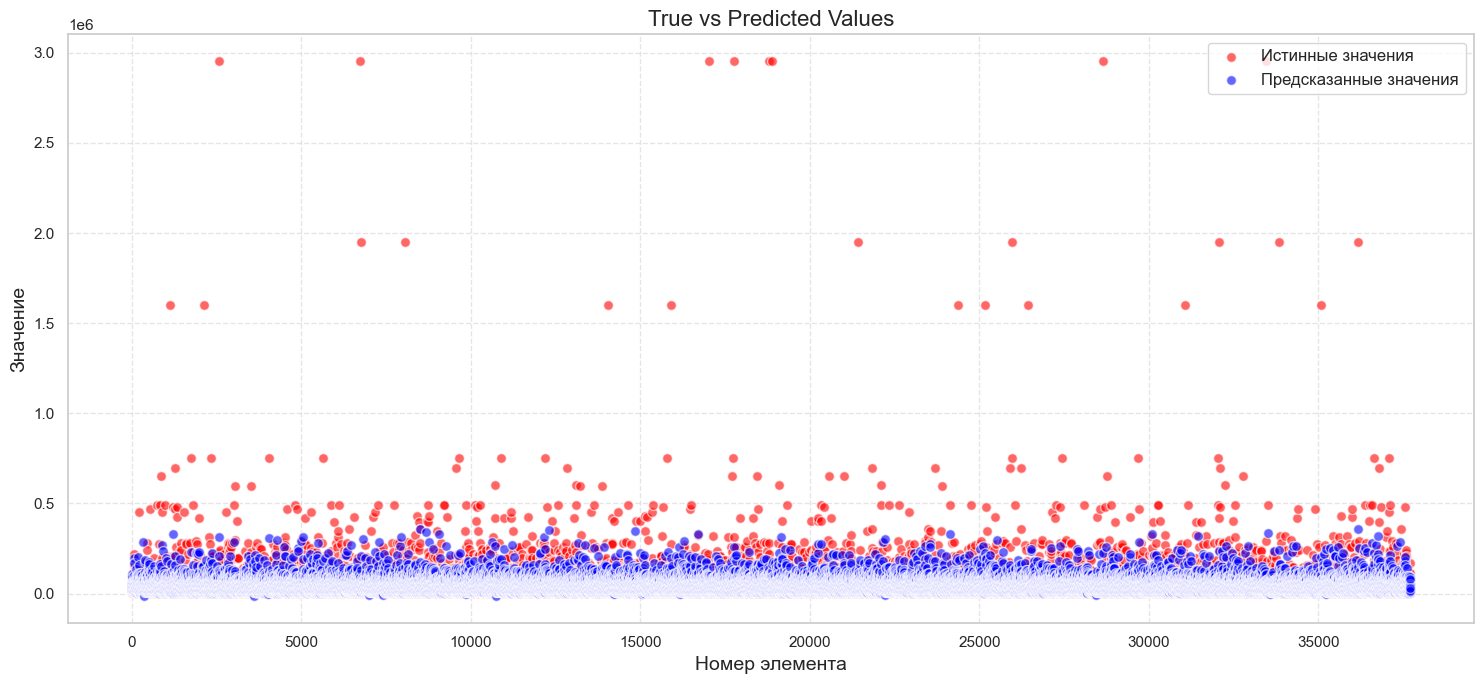

In [292]:
plot_y_test_vs_y_pred(y_test,lgb_predictions_optuna)

In [293]:
difference_lgb_optuna = abs(y_test - lgb_predictions_optuna)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


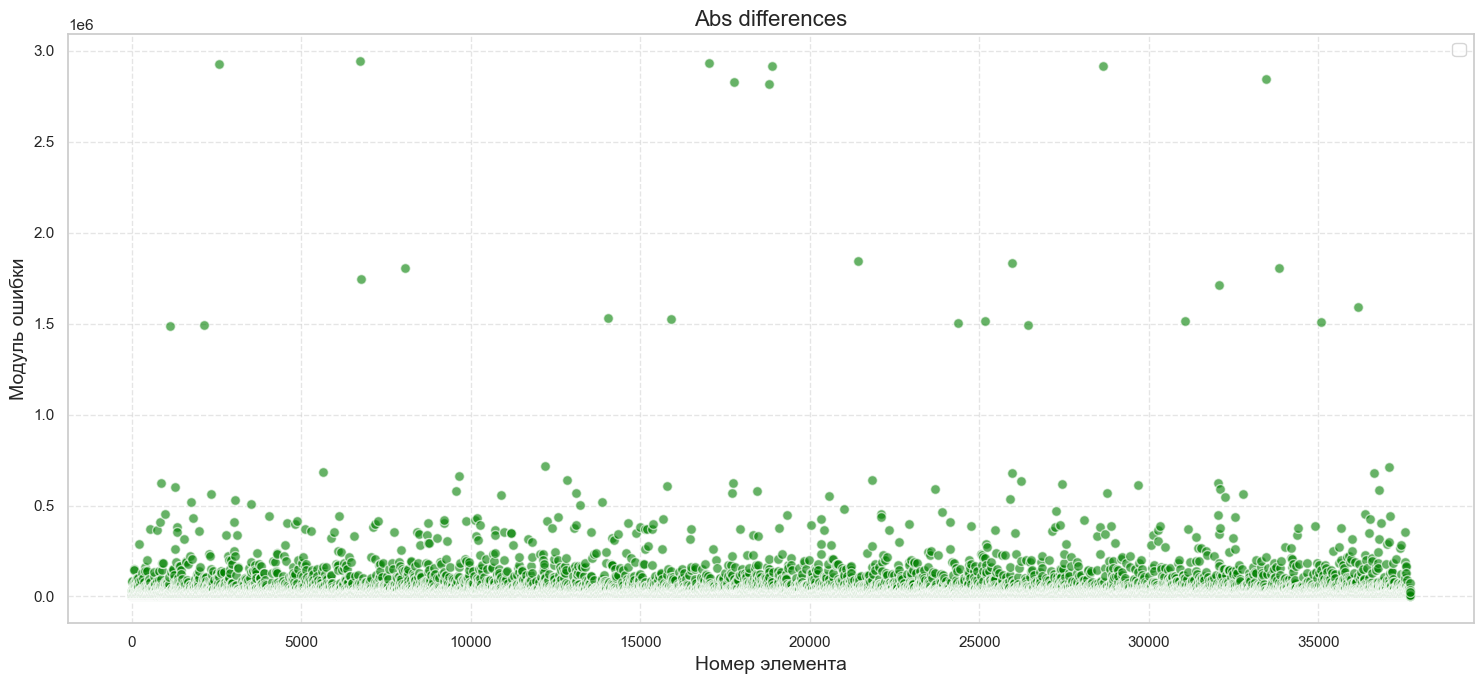

In [294]:
plot_difference(difference_lgb_optuna)

## 3. SVR

In [295]:
# Создаем экземпляр модели SVR с параметрами по умолчанию
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Обучаем модель на тренировочных данных
svr_model.fit(X_train_full, y_train_full)

SVR()

In [296]:
# Предсказания на тестовых данных
svr_predictions = svr_model.predict(X_test)

rmse_svr = mean_squared_error(y_test, svr_predictions, squared=False)
print(f'SVR RMSE на тестовых данных: {rmse_svr:.4f}')

SVR RMSE на тестовых данных: 73871.4098


milage          0.643560
engine          0.588035
model_year      0.544313
transmission    0.438428
model           0.418917
clean_title     0.160114
brand           0.152969
ext_col         0.130777
int_col         0.127387
accident        0.054207
fuel_type       0.032242
dtype: float64


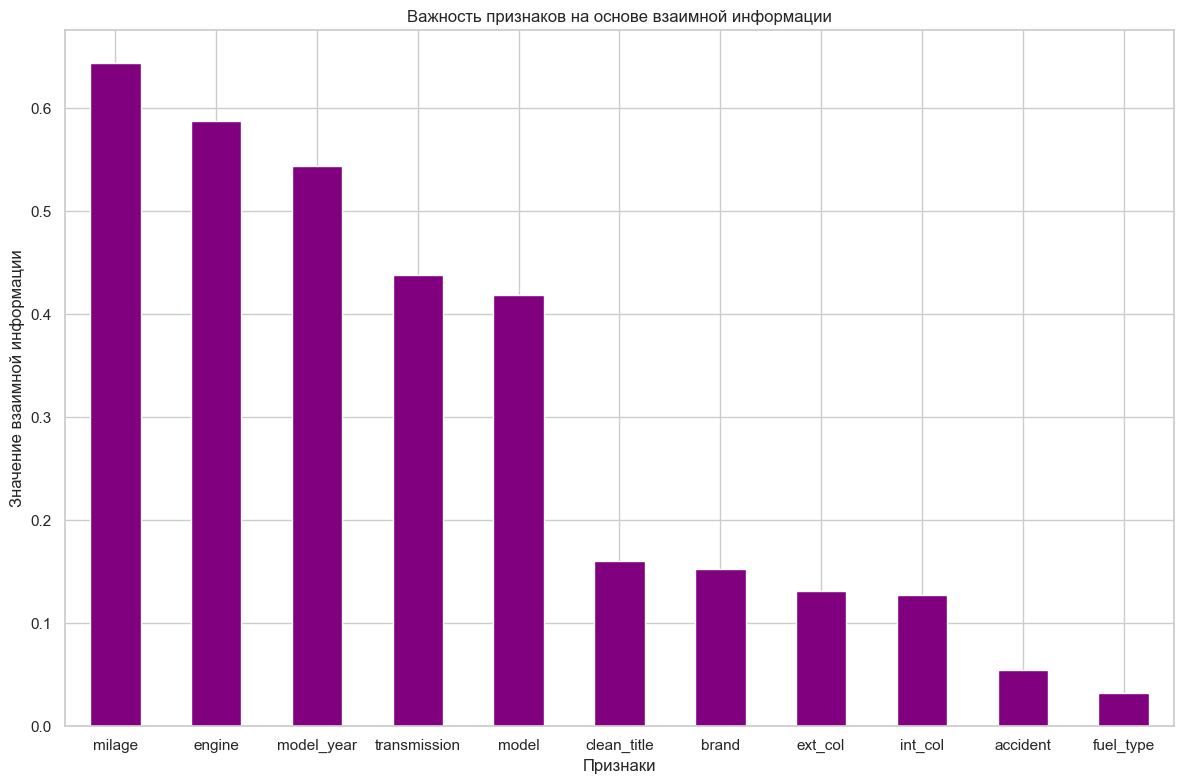

In [297]:
# Вычисляем взаимную информацию между признаками и целевой переменной
mi_scores = mutual_info_regression(X_train_full, y_train_full, random_state=42)

# Создаем Series для удобства
mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Отображаем результаты
print(mi_scores)

# Визуализация
plt.figure(figsize=(12, 8))
mi_scores.plot.bar(color='purple')
plt.title('Важность признаков на основе взаимной информации')
plt.ylabel('Значение взаимной информации')
plt.xlabel('Признаки')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/Users/vovatkachev/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


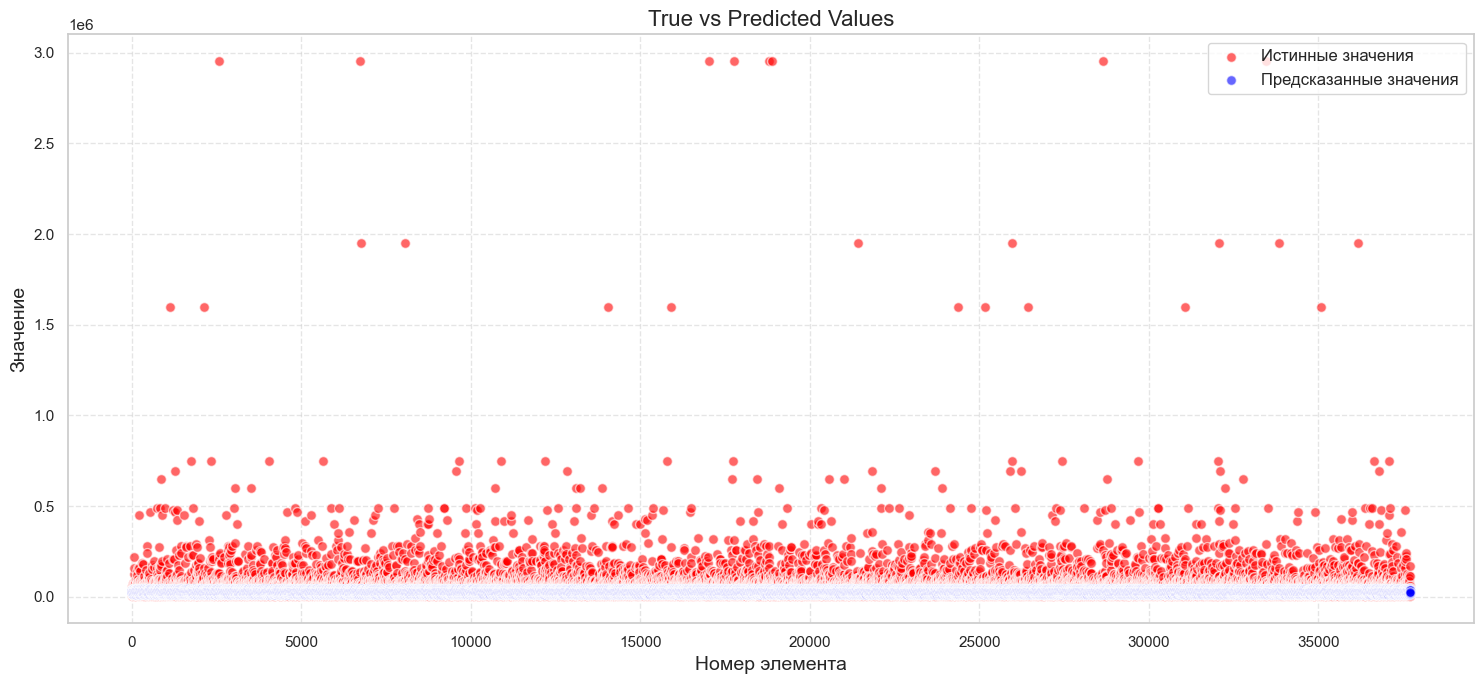

In [298]:
plot_y_test_vs_y_pred(y_test,svr_predictions)

In [299]:
difference_svr = abs(y_test - svr_predictions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


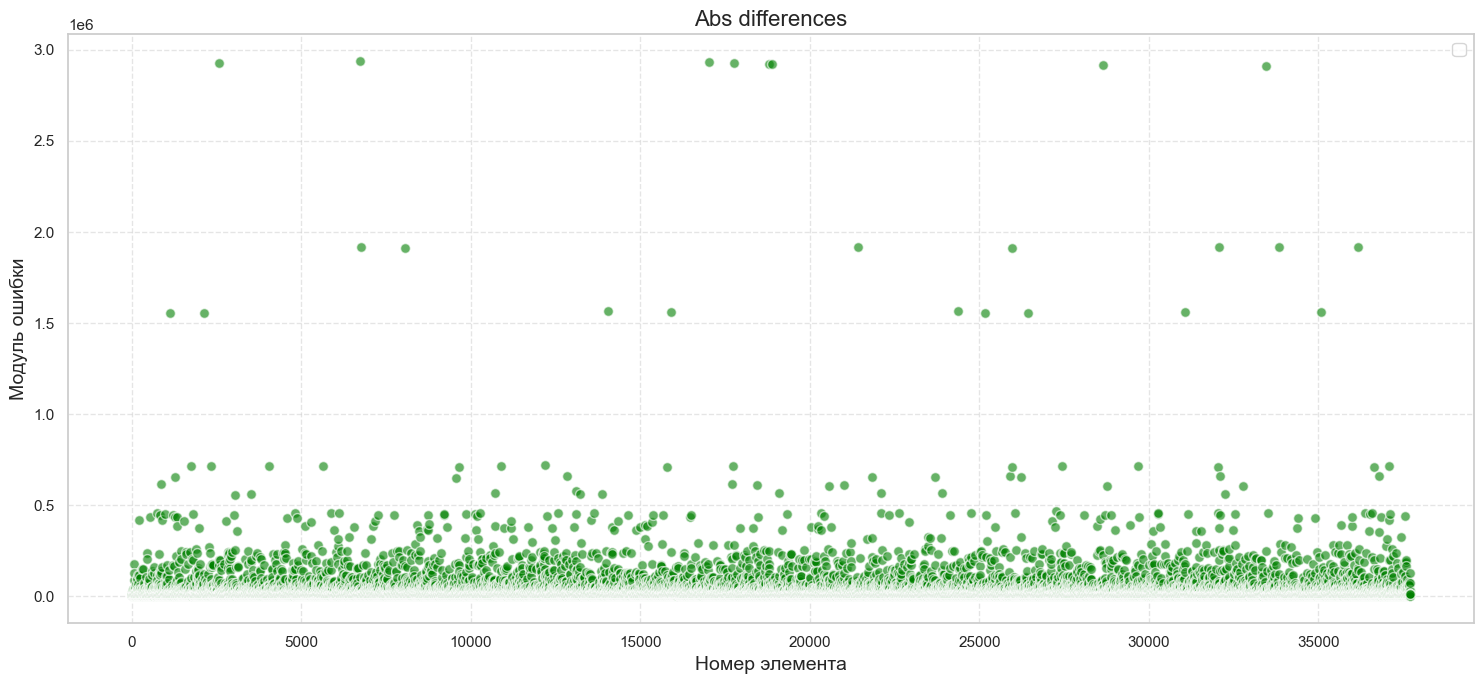

In [300]:
plot_difference(difference_svr)

## 4. NeuralNetworks

In [301]:
# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [302]:
# Конвертируем данные в тензоры
X_train_tensor = torch.tensor(X_train_full.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_full.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

In [303]:
# Функция для создания мини-батчей
def create_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

In [304]:
# Cоздаём класс для оценки важности признаков

# Обертываем модель в класс, совместимый с scikit-learn
class SklearnWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Модель уже обучена; этот метод можно оставить пустым
        pass

    def predict(self, X):
        # Преобразуем данные в тензор и перемещаем на устройство
        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X_tensor).cpu().numpy()
        return predictions.flatten()  # Преобразуем в одномерный массив

### 4.1 First model

In [305]:
class CarPricePredictor1(nn.Module):
    def __init__(self, input_dim):
        super(CarPricePredictor1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.dropout1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(16, 1)
        self.activation1 = nn.LeakyReLU()


    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation1(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [306]:
# Инициализируем модель
input_dim = X_train.shape[1]  # Количество признаков
nn1_model = CarPricePredictor1(input_dim).to(device)

In [307]:
# Определим функцию потерь и оптимизатор
criterion = nn.MSELoss()  # Функция потерь для задачи регрессии (MSE)
optimizer = optim.Adam(nn1_model.parameters(), lr=0.03,weight_decay=1e-5)  # Оптимизатор Adam

In [308]:
# Обучение модели
num_epochs = 500
batch_size = 10000
patience = 20

In [309]:
for epoch in range(num_epochs):
    nn1_model.train()  # Установим модель в режим тренировки
    epoch_loss = 0
    total_samples = 0
    for X_batch, y_batch in create_batches(X_train_tensor, y_train_tensor, batch_size):
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = nn1_model(X_batch)  # Прямой проход
        loss = criterion(outputs, y_batch)  # Вычисляем ошибку
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса
        batch_size_actual = X_batch.size(0)
        epoch_loss += loss.item() * batch_size_actual  # Суммируем потери, умноженные на размер батча
        total_samples += batch_size_actual

    # Вычисляем средний MSE и RMSE за эпоху
    epoch_mse = epoch_loss / total_samples
    epoch_rmse = np.sqrt(epoch_mse)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], RMSE: {epoch_rmse:.4f}')

Epoch [10/500], RMSE: 75398.3130
Epoch [20/500], RMSE: 74962.3563
Epoch [30/500], RMSE: 74696.8335
Epoch [40/500], RMSE: 74603.5092
Epoch [50/500], RMSE: 74589.9886
Epoch [60/500], RMSE: 74593.7286
Epoch [70/500], RMSE: 74505.7202
Epoch [80/500], RMSE: 74411.6088
Epoch [90/500], RMSE: 74388.4793
Epoch [100/500], RMSE: 74322.9193
Epoch [110/500], RMSE: 74446.5236
Epoch [120/500], RMSE: 74385.3466
Epoch [130/500], RMSE: 74333.4032
Epoch [140/500], RMSE: 74248.8033
Epoch [150/500], RMSE: 74398.7656
Epoch [160/500], RMSE: 74295.4702
Epoch [170/500], RMSE: 74273.0846
Epoch [180/500], RMSE: 74265.7202
Epoch [190/500], RMSE: 74252.4494
Epoch [200/500], RMSE: 74335.6707
Epoch [210/500], RMSE: 74297.9369
Epoch [220/500], RMSE: 74310.3762
Epoch [230/500], RMSE: 74213.7468
Epoch [240/500], RMSE: 74261.0335
Epoch [250/500], RMSE: 74331.2874
Epoch [260/500], RMSE: 74311.0697
Epoch [270/500], RMSE: 74226.1904
Epoch [280/500], RMSE: 74229.2635
Epoch [290/500], RMSE: 74396.1342
Epoch [300/500], RMSE: 

In [310]:
# Оценка модели на тестовых данных
nn1_model.eval()  # Установим модель в режим оценки
with torch.no_grad():
    # y_pred_train = model(X_train_tensor)
    nn1_predictions = nn1_model(X_test_tensor)

    # Вычисляем RMSE
    # train_rmse = mean_squared_error(y_train_tensor.cpu(), y_pred_train.cpu(), squared=False)
    test_rmse = mean_squared_error(y_test_tensor.cpu(), nn1_predictions.cpu(), squared=False)

    # print(f'Train RMSE: {train_rmse:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 68143.6172


         Признак  Важность (%)
3         milage     48.060864
5         engine     23.380381
1          model     12.702501
2     model_year     10.499237
7        ext_col      1.698459
9       accident      1.348067
10   clean_title      0.885735
6   transmission      0.666499
0          brand      0.457734
4      fuel_type      0.177815
8        int_col      0.122707


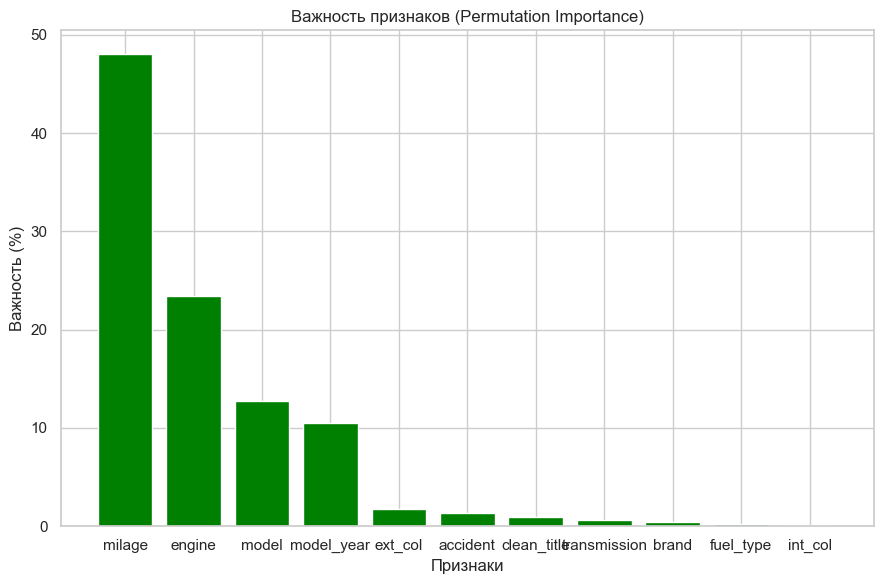

In [311]:
# Создаем экземпляр обертки
wrapped_model = SklearnWrapper(nn1_model)

# Используем permutation_importance
result = permutation_importance(
    estimator=wrapped_model,
    X=X_test,
    y=y_test,
    scoring='neg_root_mean_squared_error',  # Используем RMSE
    n_repeats=10,
    random_state=42
)

# Получаем важности признаков
feature_importances = result.importances_mean

# Вычисляем процентную важность
feature_importances_percent = 100 * feature_importances / np.sum(feature_importances)

# Создаем DataFrame с результатами
importance_df = pd.DataFrame({
    'Признак': X.columns,
    'Важность (%)': feature_importances_percent
})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)

# Отображаем результаты
print(importance_df)

# Визуализация важности признаков
plt.figure(figsize=(9, 6))
plt.bar(importance_df['Признак'], importance_df['Важность (%)'], color='green')

plt.xlabel('Признаки')
plt.ylabel('Важность (%)')
plt.title('Важность признаков (Permutation Importance)')
plt.xticks(rotation=0)  # Поворачиваем подписи на оси X, чтобы они не накладывались
plt.tight_layout()
plt.show()

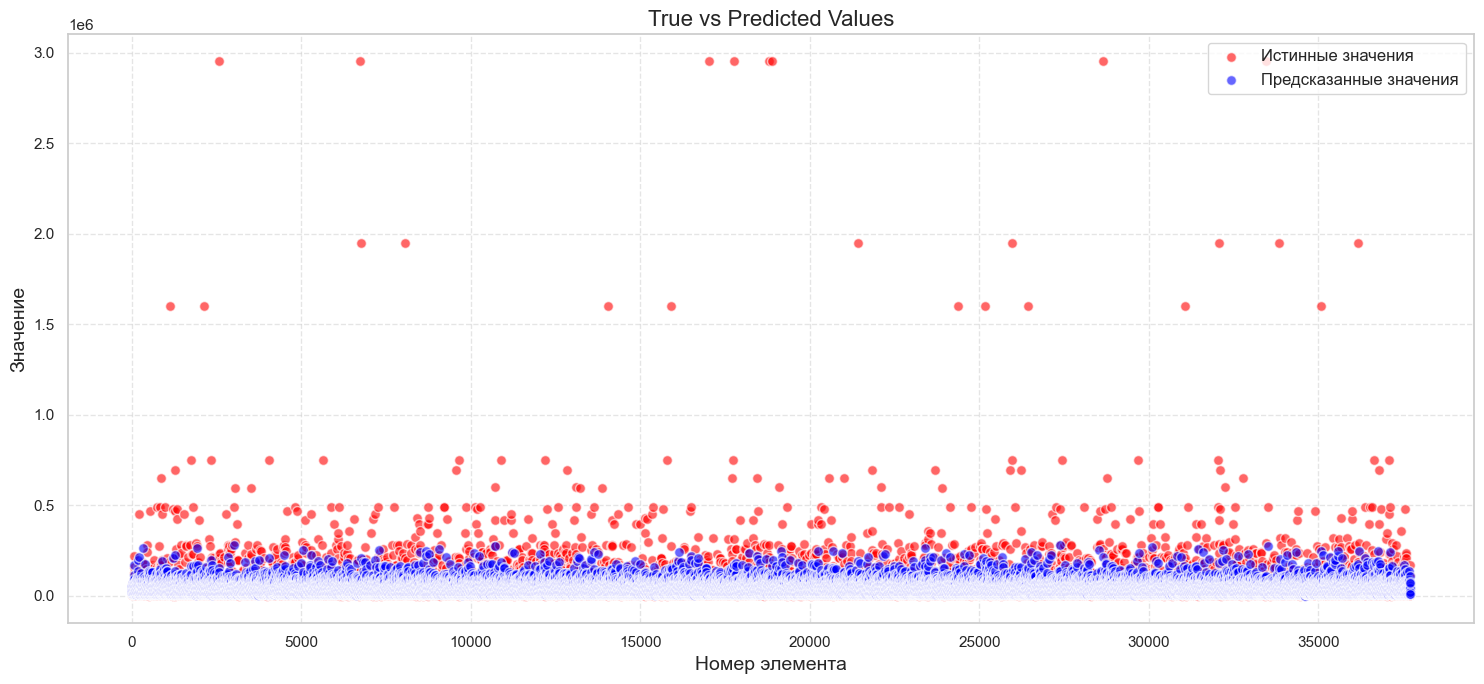

In [312]:
plot_y_test_vs_y_pred(y_test,nn1_predictions)

### 4.2 Second model

In [313]:
class CarPricePredictor2(nn.Module):
    def __init__(self, input_dim):
        super(CarPricePredictor2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.dropout1 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(16, 8)
        self.dropout2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(8, 4)
        self.dropout3 = nn.Dropout(p=0.1)
        self.fc4 = nn.Linear(4, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.activation(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [314]:
# Инициализируем модель
input_dim = X_train.shape[1]  # Количество признаков
nn2_model = CarPricePredictor2(input_dim).to(device)

In [315]:
# Определим функцию потерь и оптимизатор
criterion = nn.MSELoss()  # Функция потерь для задачи регрессии (MSE)
optimizer = optim.Adam(nn2_model.parameters(), lr=0.03,weight_decay=1e-5)  # Оптимизатор Adam

In [316]:
# Обучение модели
num_epochs = 500
batch_size = 10000
patience = 20

In [317]:
for epoch in range(num_epochs):
    nn2_model.train()  # Установим модель в режим тренировки
    epoch_loss = 0
    total_samples = 0
    for X_batch, y_batch in create_batches(X_train_tensor, y_train_tensor, batch_size):
        optimizer.zero_grad()  # Обнуляем градиенты
        outputs = nn2_model(X_batch)  # Прямой проход
        loss = criterion(outputs, y_batch)  # Вычисляем ошибку
        loss.backward()  # Обратное распространение ошибки
        optimizer.step()  # Обновляем веса
        batch_size_actual = X_batch.size(0)
        epoch_loss += loss.item() * batch_size_actual  # Суммируем потери, умноженные на размер батча
        total_samples += batch_size_actual

    # Вычисляем средний MSE и RMSE за эпоху
    epoch_mse = epoch_loss / total_samples
    epoch_rmse = np.sqrt(epoch_mse)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], RMSE: {epoch_rmse:.4f}')

Epoch [10/500], RMSE: 77233.8745
Epoch [20/500], RMSE: 76631.0094
Epoch [30/500], RMSE: 76420.6852
Epoch [40/500], RMSE: 76364.3213
Epoch [50/500], RMSE: 76414.0589
Epoch [60/500], RMSE: 76391.7101
Epoch [70/500], RMSE: 76374.3564
Epoch [80/500], RMSE: 76336.4568
Epoch [90/500], RMSE: 76295.2779
Epoch [100/500], RMSE: 76229.0200
Epoch [110/500], RMSE: 76281.9865
Epoch [120/500], RMSE: 76326.9596
Epoch [130/500], RMSE: 76269.8964
Epoch [140/500], RMSE: 76219.0736
Epoch [150/500], RMSE: 76302.7287
Epoch [160/500], RMSE: 76146.2769
Epoch [170/500], RMSE: 76184.7195
Epoch [180/500], RMSE: 76076.6326
Epoch [190/500], RMSE: 76325.5115
Epoch [200/500], RMSE: 76377.1754
Epoch [210/500], RMSE: 76198.8415
Epoch [220/500], RMSE: 76227.5922
Epoch [230/500], RMSE: 76245.4859
Epoch [240/500], RMSE: 76115.0577
Epoch [250/500], RMSE: 76224.4477
Epoch [260/500], RMSE: 76274.7328
Epoch [270/500], RMSE: 76334.0129
Epoch [280/500], RMSE: 76029.9048
Epoch [290/500], RMSE: 76213.4530
Epoch [300/500], RMSE: 

In [318]:
# Оценка модели на тестовых данных
nn2_model.eval()  # Установим модель в режим оценки
with torch.no_grad():
    # y_pred_train = model(X_train_tensor)
    nn2_predictions = nn2_model(X_test_tensor)

    # Вычисляем RMSE
    # train_rmse = mean_squared_error(y_train_tensor.cpu(), y_pred_train.cpu(), squared=False)
    test_rmse = mean_squared_error(y_test_tensor.cpu(), nn2_predictions.cpu(), squared=False)

    # print(f'Train RMSE: {train_rmse:.4f}')
    print(f'Test RMSE: {test_rmse:.4f}')

Test RMSE: 68454.4453


         Признак  Важность (%)
3         milage     46.081170
5         engine     26.186915
1          model     14.750833
2     model_year      6.507077
7        ext_col      2.321350
9       accident      2.069293
6   transmission      1.493254
8        int_col      0.336998
10   clean_title      0.210773
0          brand      0.170929
4      fuel_type     -0.128594


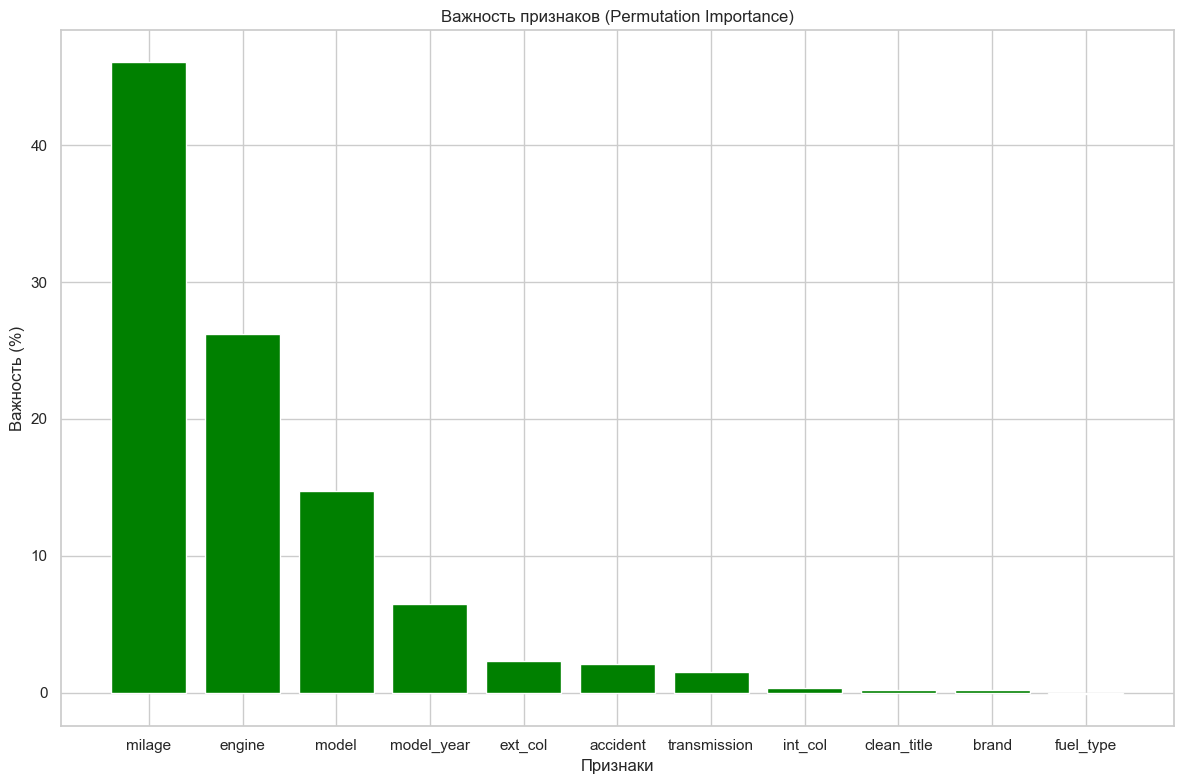

In [319]:
# Создаем экземпляр обертки
wrapped_model = SklearnWrapper(nn2_model)

# Используем permutation_importance
result = permutation_importance(
    estimator=wrapped_model,
    X=X_test,
    y=y_test,
    scoring='neg_root_mean_squared_error',  # Используем RMSE
    n_repeats=10,
    random_state=42
)

# Получаем важности признаков
feature_importances = result.importances_mean

# Вычисляем процентную важность
feature_importances_percent = 100 * feature_importances / np.sum(feature_importances)

# Создаем DataFrame с результатами
importance_df = pd.DataFrame({
    'Признак': X.columns,
    'Важность (%)': feature_importances_percent
})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)

# Отображаем результаты
print(importance_df)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
plt.bar(importance_df['Признак'], importance_df['Важность (%)'], color='green')

plt.xlabel('Признаки')
plt.ylabel('Важность (%)')
plt.title('Важность признаков (Permutation Importance)')
plt.xticks(rotation=0)  # Поворачиваем подписи на оси X, чтобы они не накладывались
plt.tight_layout()
plt.show()

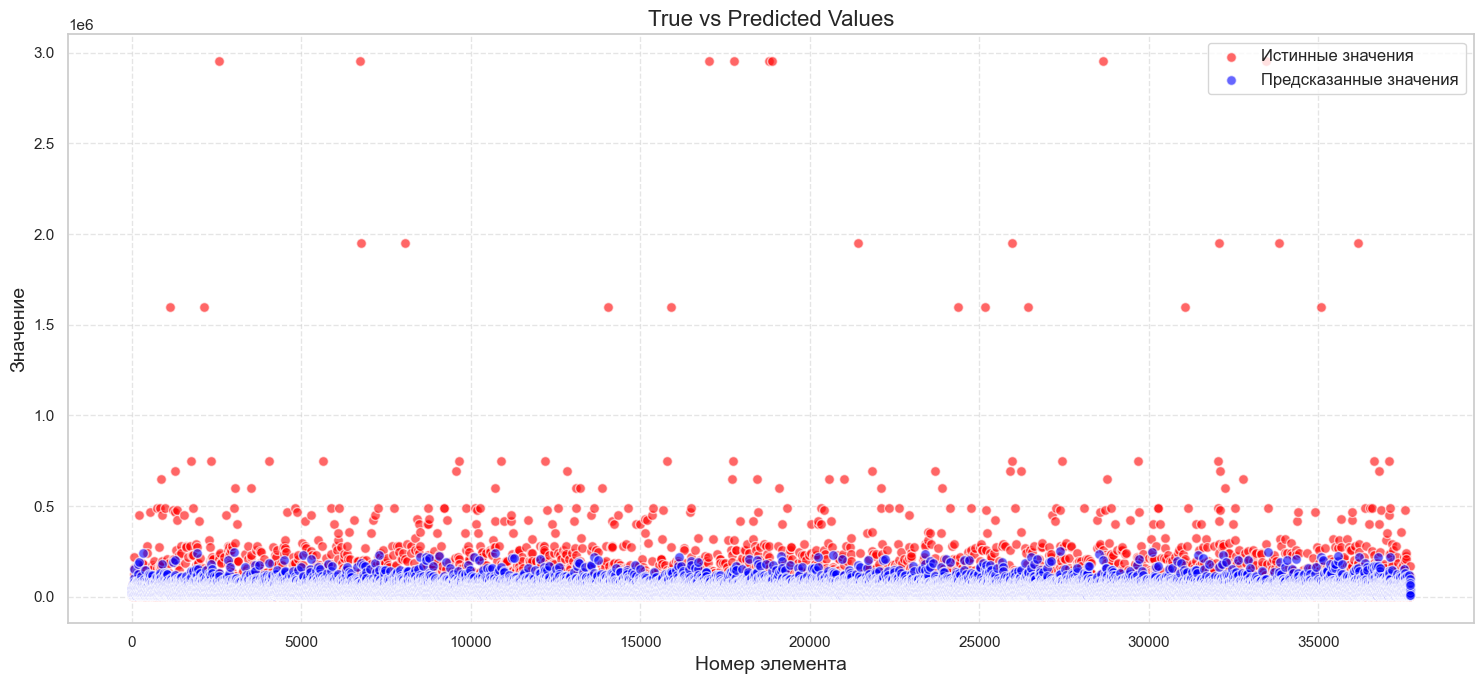

In [320]:
plot_y_test_vs_y_pred(y_test,nn2_predictions)


## 5. Linear Models

### 5.1 LinearRegression

In [321]:
lr_model = LinearRegression()
lr_model.fit(X_train_full, y_train_full)

LinearRegression()

In [322]:
# Предсказания для XGBoost
lr_predictions = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
print(f'RMSE для LinearRegression: {lr_rmse}')

RMSE для LinearRegression: 68776.1761427296


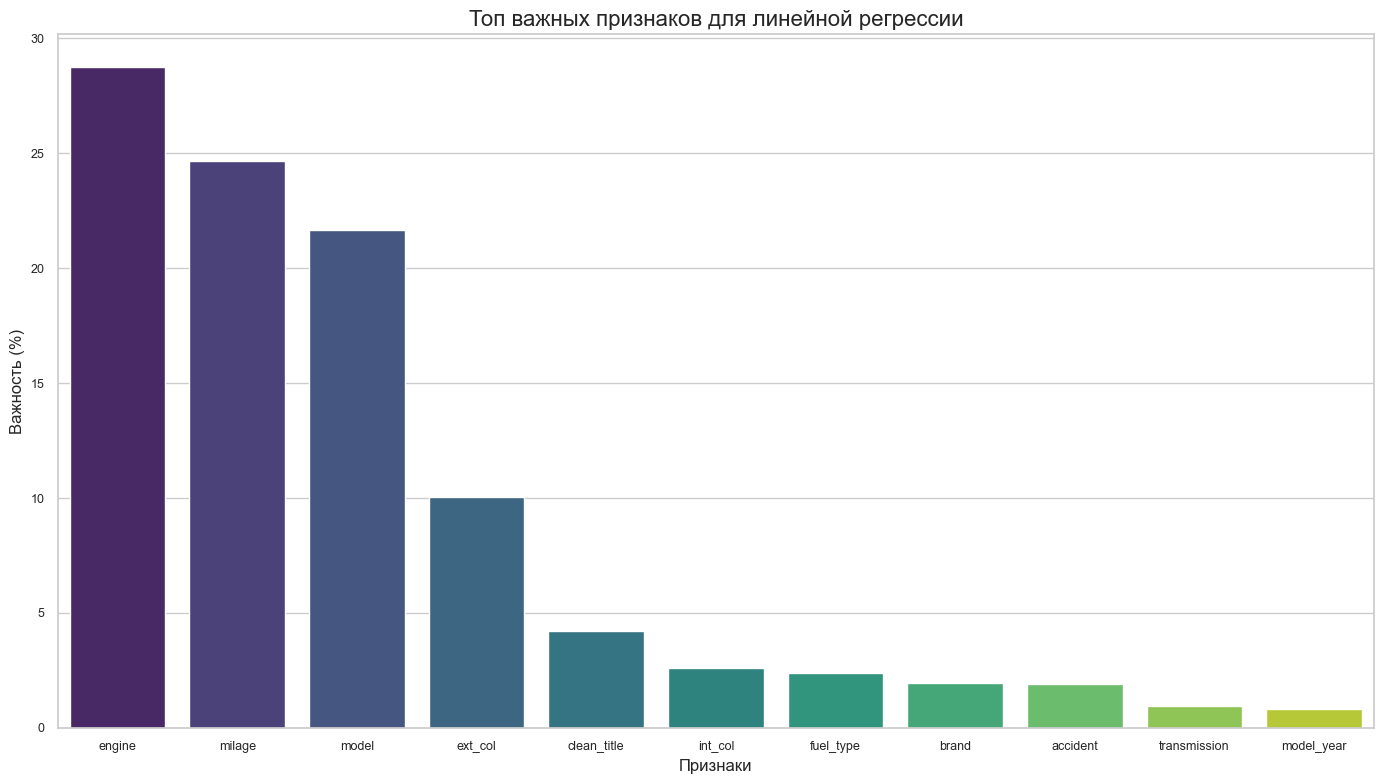

In [323]:
# 3. Получение коэффициентов модели
coefficients = lr_model.coef_

# 4. Вычисление абсолютных значений коэффициентов для важности
importance = np.abs(coefficients)

# 5. Преобразование важности в проценты
importance_percentage = 100 * (importance / importance.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# 6. Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

plt.title("Топ важных признаков для линейной регрессии", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

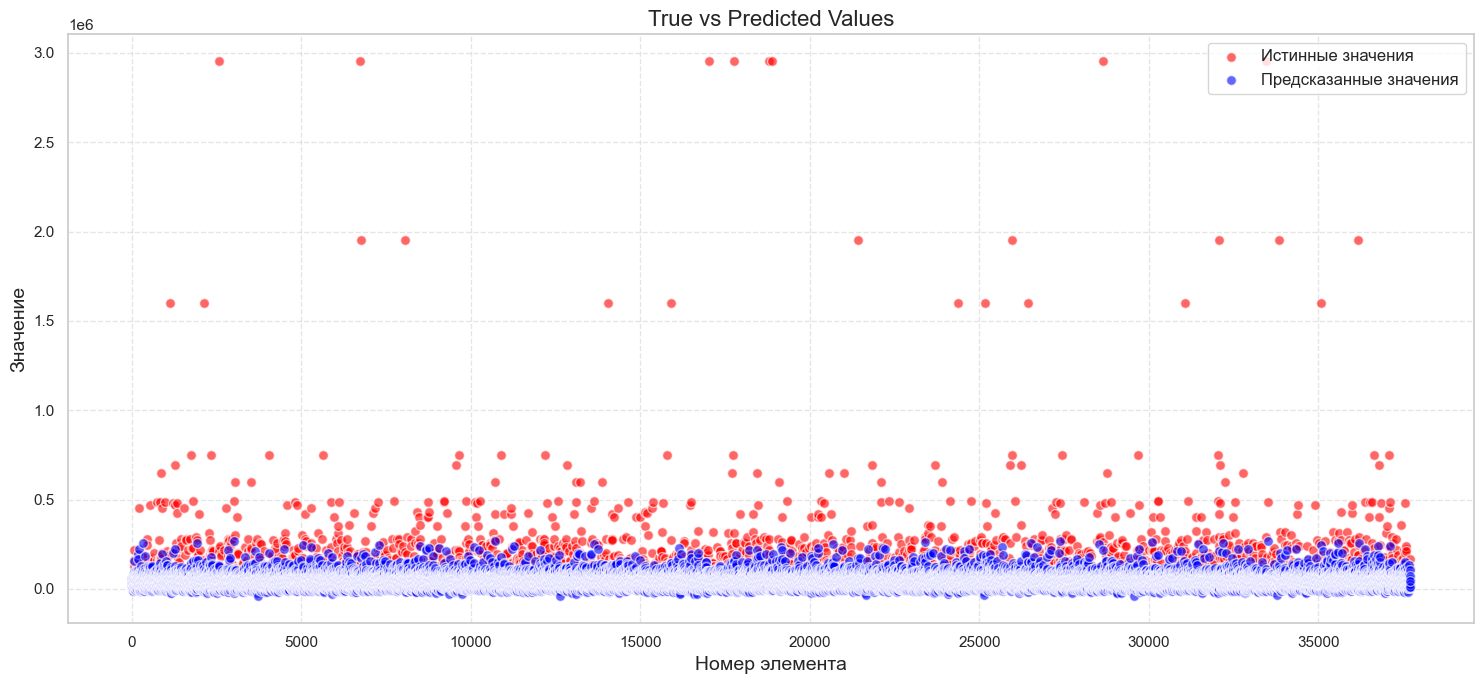

In [324]:
plot_y_test_vs_y_pred(y_test,lr_predictions)

### 5.2 Ridge

In [325]:
ridge_model = Ridge()
ridge_model.fit(X_train_full, y_train_full)

Ridge()

In [326]:
# Предсказания для XGBoost
ridge_predictions = ridge_model.predict(X_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_predictions))
print(f'RMSE для Ridge: {ridge_rmse}')

RMSE для Ridge: 68776.17378323237


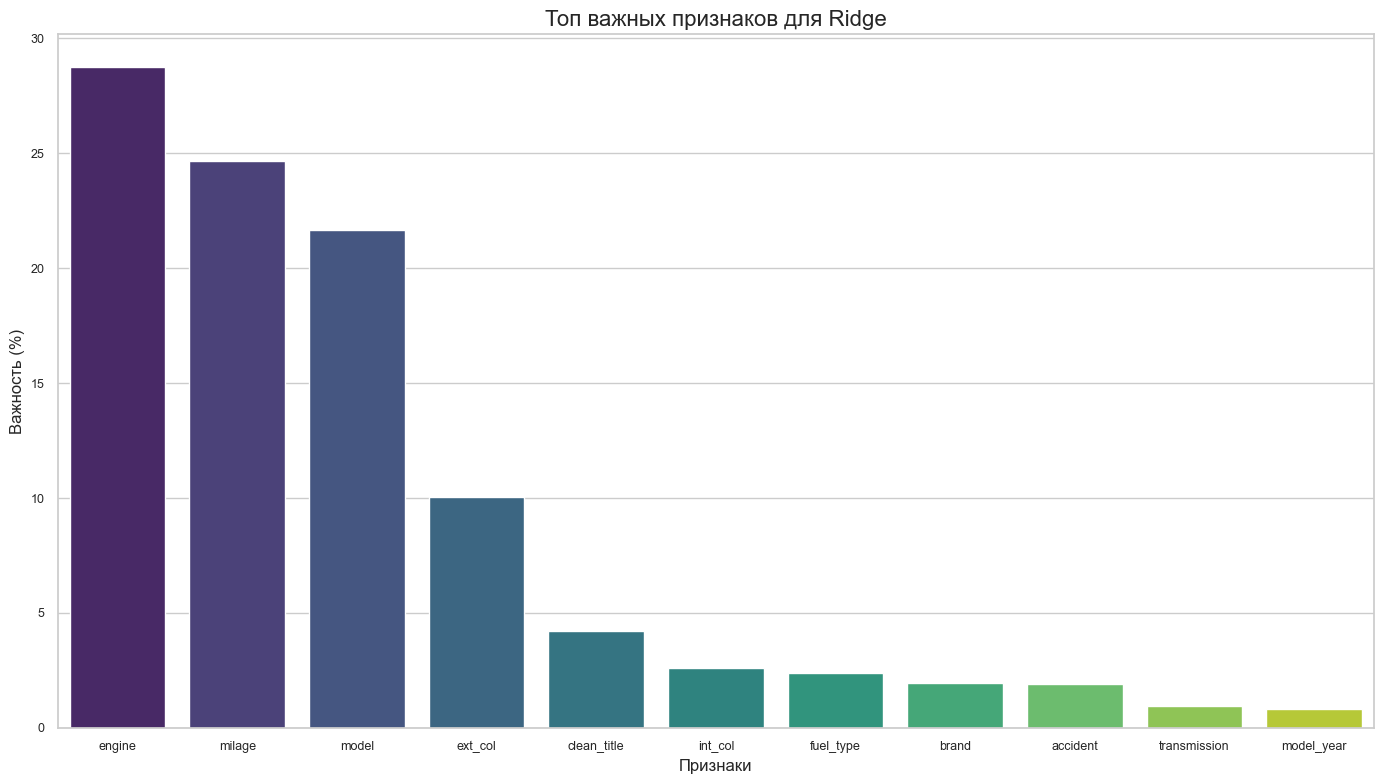

In [327]:
# 3. Получение коэффициентов модели
coefficients = ridge_model.coef_

# 4. Вычисление абсолютных значений коэффициентов для важности
importance = np.abs(coefficients)

# 5. Преобразование важности в проценты
importance_percentage = 100 * (importance / importance.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# 6. Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')

plt.title("Топ важных признаков для Ridge", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

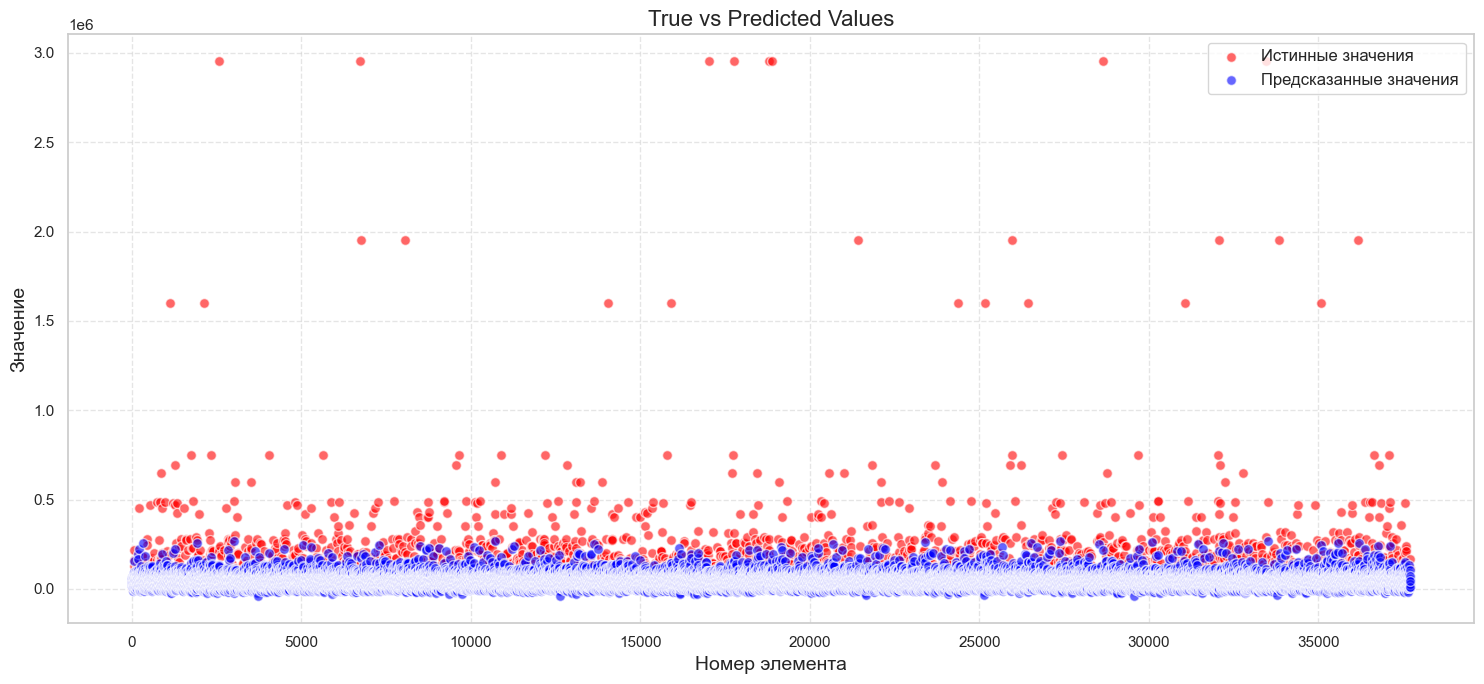

In [328]:
plot_y_test_vs_y_pred(y_test,ridge_predictions)

## 6. Random Forest

In [343]:
rf_model = RandomForestRegressor(
    n_estimators=1000,          # Количество деревьев в лесу
    max_depth=None,            # Максимальная глубина дерева
    random_state=42,           # Для воспроизводимости результатов
    n_jobs=-1                  # Использовать все доступные ядра процессора
)
rf_model.fit(X_train_full, y_train_full)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)

In [344]:
# Предсказания для RandomForestRegressor
rf_predictions = rf_model.predict(X_test)

# Оценка модели с использованием RMSE
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f'RMSE для RandomForestRegressor: {rf_rmse}')

RMSE для RandomForestRegressor: 73583.73366754928


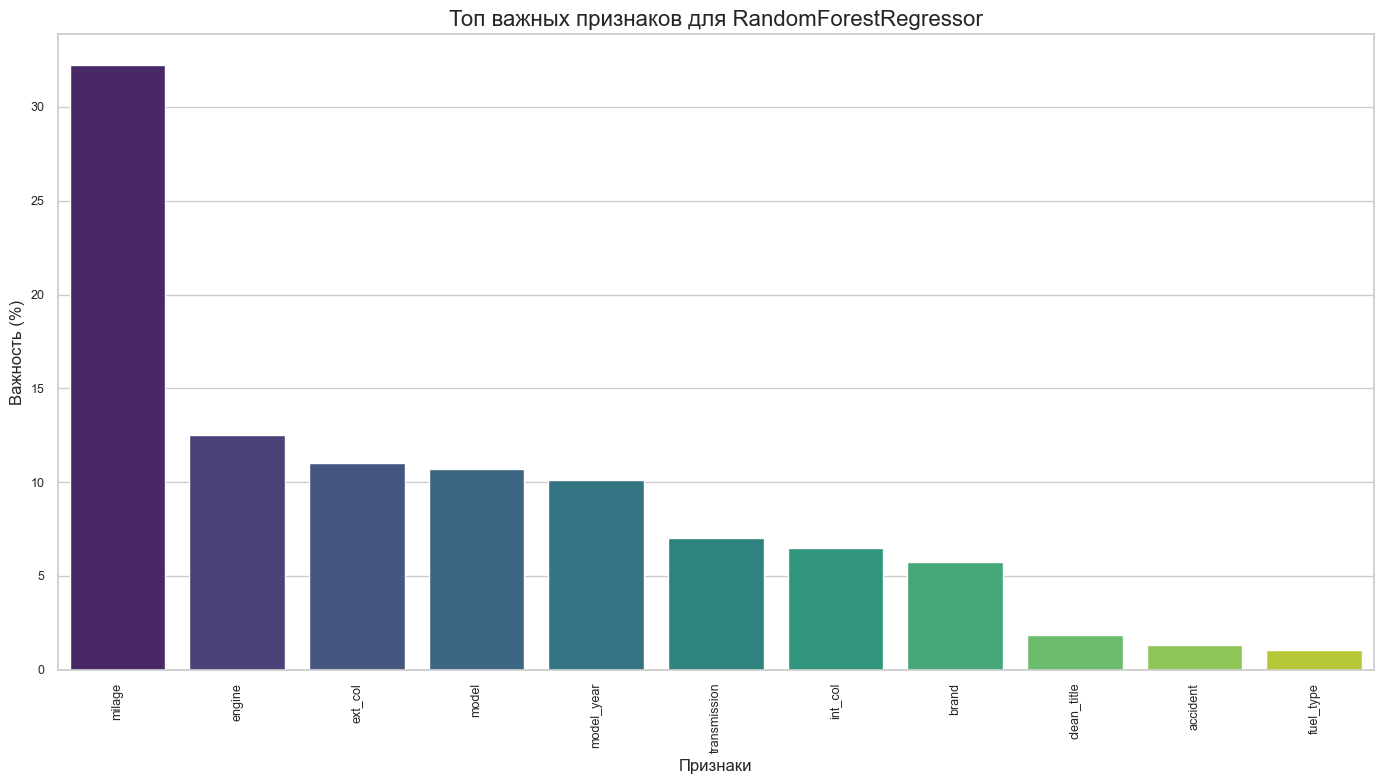

In [345]:
# Получение важности признаков
feature_importances = rf_model.feature_importances_

# Преобразование важности в проценты
importance_percentage = 100 * (feature_importances / feature_importances.sum())

# Создание DataFrame с именами признаков и их процентной важностью
feature_names = X.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (%)': importance_percentage
})

# Сортировка признаков по убыванию важности
importance_df = importance_df.sort_values(by='Важность (%)', ascending=False)


# Построение вертикального столбчатого графика
plt.figure(figsize=(14, 8))
sns.barplot(x='Признак', y='Важность (%)', data=importance_df, palette='viridis')


plt.title("Топ важных признаков для RandomForestRegressor", fontsize=16)
plt.xlabel("Признаки", fontsize=12)
plt.ylabel("Важность (%)", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

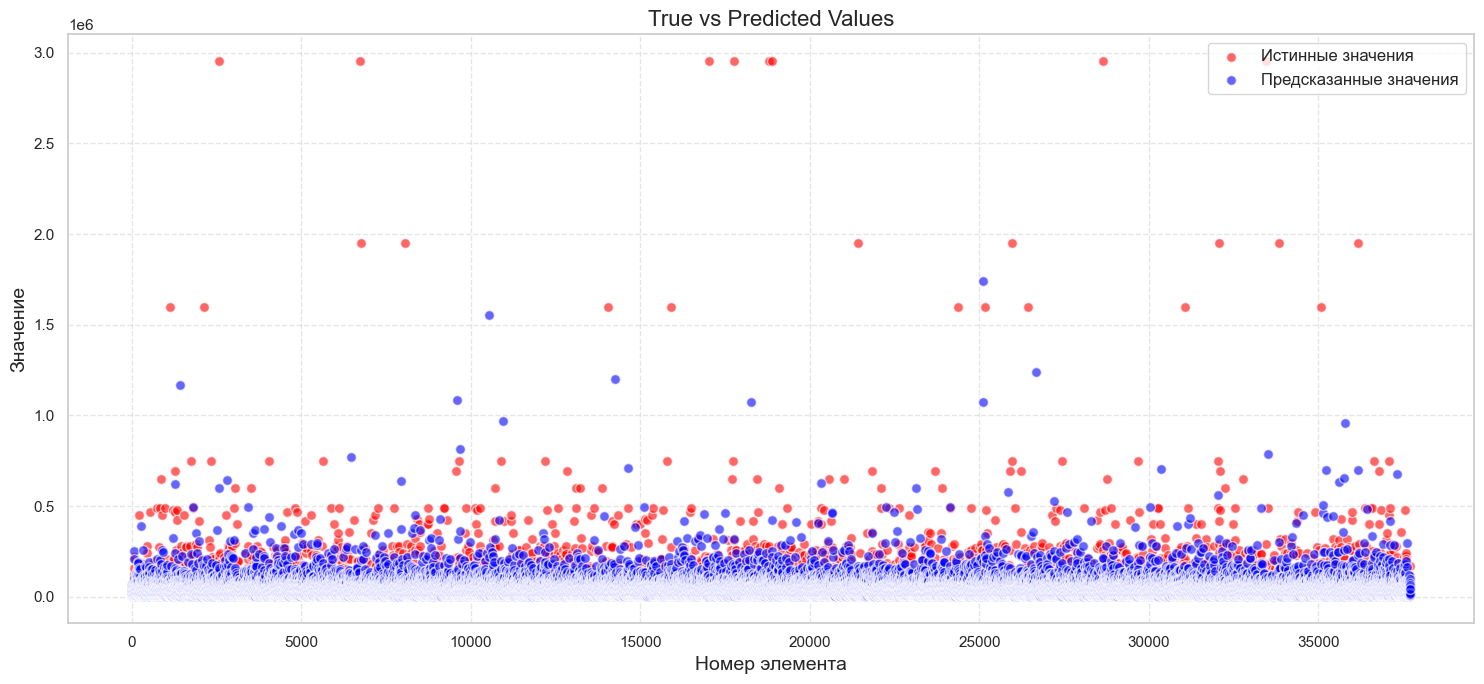

In [335]:
plot_y_test_vs_y_pred(y_test,rf_predictions)

# Мета-модель